In [1]:
import eispac
import numpy as np
import matplotlib.pyplot as plt
import sunpy
import sunpy.map
import pandas as pd
import os
import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.constants as const
from regions import (PolygonSkyRegion,EllipsePixelRegion, PixCoord)
import shapely
from scipy.io import readsav
import scipy.interpolate
from astropy.visualization import (ImageNormalize, SqrtStretch, 
                                   AsinhStretch, LogStretch)
from eis_straylight import calc_short_range_stray_light, calc_long_range_stray_light_aia_eis, coalign_eis_aia
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoMinorLocator
import cmcrameri.cm as cmcm
import corner

In [2]:
aia_131_map = sunpy.map.Map('../../src/AIA/20221025/131/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.131.image.fits')
aia_171_map = sunpy.map.Map('../../src/AIA/20221025/171/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.171.image.fits')
aia_193_map = sunpy.map.Map('../../src/AIA/20221025/193/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.193.image.fits')
aia_211_map = sunpy.map.Map('../../src/AIA/20221025/211/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.211.image.fits')
aia_335_map = sunpy.map.Map('../../src/AIA/20221025/335/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.335.image.fits')
aia_94_map = sunpy.map.Map('../../src/AIA/20221025/94/lvl15/aia.lev1_euv_12s.2022-10-25T022003Z.94.image.fits')

In [3]:
eis_file_prefix = '../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.'

In [4]:
eis_FeXII_195_fitres = eispac.read_fit(eis_file_prefix + 'fe_12_195_119.1c-0.fit.h5')
eis_FeXII_195_intmap = eis_FeXII_195_fitres.get_map(component=0, measurement='intensity')
eis_FeXII_195_velmap = eis_FeXII_195_fitres.get_map(component=0, measurement='velocity')
eis_FeXII_195_widmap = eis_FeXII_195_fitres.get_map(component=0, measurement='width')

Txshift_aia_eis_rough, Tyshift_aia_eis_rough = coalign_eis_aia(eis_FeXII_195_intmap, aia_193_map)
eis_FeXII_195_intmap = eis_FeXII_195_intmap.shift_reference_coord(Txshift_aia_eis_rough, Tyshift_aia_eis_rough)
eis_FeXII_195_velmap = eis_FeXII_195_velmap.shift_reference_coord(Txshift_aia_eis_rough, Tyshift_aia_eis_rough)
eis_FeXII_195_widmap = eis_FeXII_195_widmap.shift_reference_coord(Txshift_aia_eis_rough, Tyshift_aia_eis_rough)

c = const.c.cgs.value
amu = const.u.cgs.value
k_B = const.k_B.cgs.value

FeXII_195_true_width_fwhm = np.sqrt((eis_FeXII_195_widmap.data * np.sqrt(8*np.log(2)))**2 - \
                                    eis_FeXII_195_fitres.meta["slit_width"][:,np.newaxis]**2)
FeXII_195_v1oe = FeXII_195_true_width_fwhm/np.sqrt(4*np.log(2))*c/195.119
FeXII_195_vth2 = 2*k_B*10**6.25/amu/55.85
FeXII_195_vnth = np.sqrt(FeXII_195_v1oe**2 - FeXII_195_vth2)
eis_FeXII_195_vnthmap = sunpy.map.Map(FeXII_195_vnth/1e5, eis_FeXII_195_widmap.meta)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_12_195_119.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_664509/2815883421.py:15: RuntimeWarning: invalid value encountered in sqrt
  FeXII_195_true_width_fwhm = np.sqrt((eis_FeXII_195_widmap.data * np.sqrt(8*np.log(2)))**2 - \
/tmp/ipykernel_664509/2815883421.py:19: RuntimeWarning: invalid value encountered in sqrt
  FeXII_195_vnth = np.sqrt(FeXII_195_v1oe**2 - FeXII_195_vth2)


In [5]:
eis_FeXII_195_intmap.wcs.pixel_to_world(0,0)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


<SkyCoord (Helioprojective: obstime=2022-10-25T02:20:09.500, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2022-10-25T02:20:09.500, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., 5.06930246, 1.48785902e+11)>): (Tx, Ty) in arcsec
    (-464.64207691, -67.19205778)>

In [7]:
eis_FeXII_195_intmap.meta['date_obs']

'2022-10-25T01:48:11.000'

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


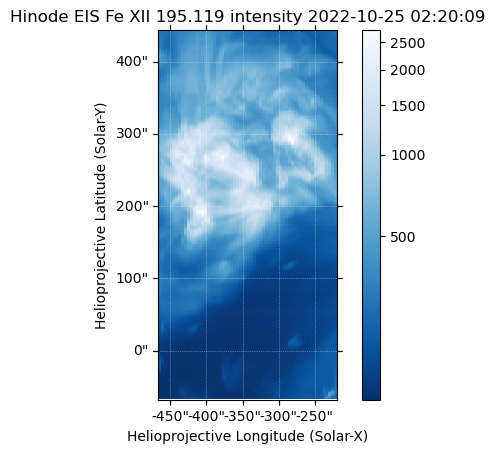

In [34]:
eis_FeXII_195_intmap.plot()
plt.colorbar()

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


(150.0, 350.0)

/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations small

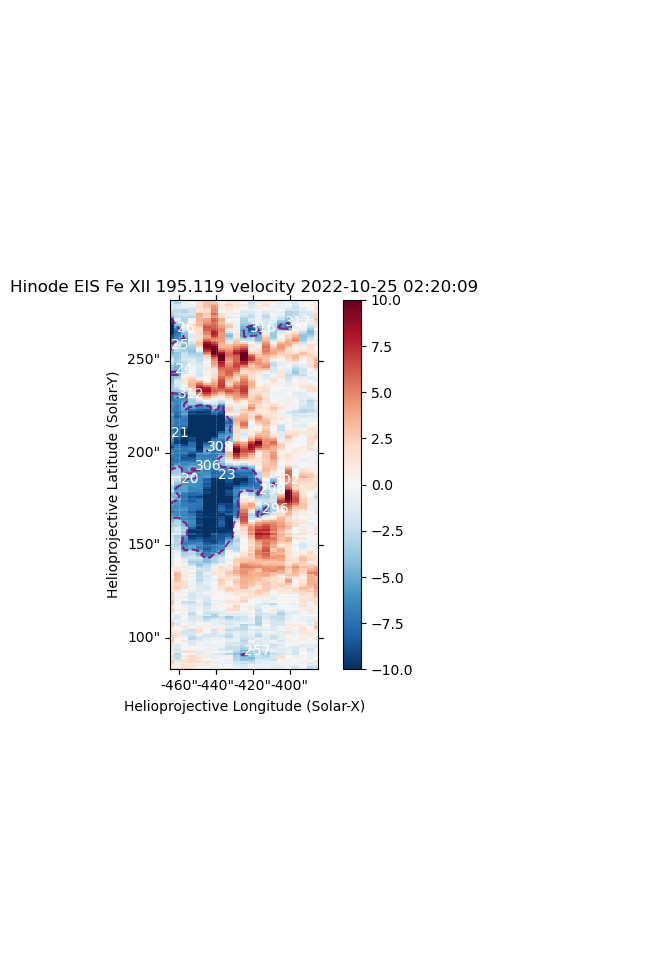

In [35]:
fig = plt.figure(layout='constrained')

ax = fig.add_subplot(111, projection=eis_FeXII_195_velmap)
eis_FeXII_195_velmap.plot(axes=ax)

cs = eis_FeXII_195_velmap.draw_contours(levels=[-5,]*eis_FeXII_195_velmap.unit,colors=["purple"],axes=ax,alpha=0.8)
plt.colorbar()

for ii, seg in enumerate(cs.allsegs[0]):
    ax.text(np.nanmean(seg, axis=0)[0], np.nanmean(seg, axis=0)[1], f'{ii}', color='white', fontsize=10)

ax.set_xlim(0,20)
ax.set_ylim(150,350)

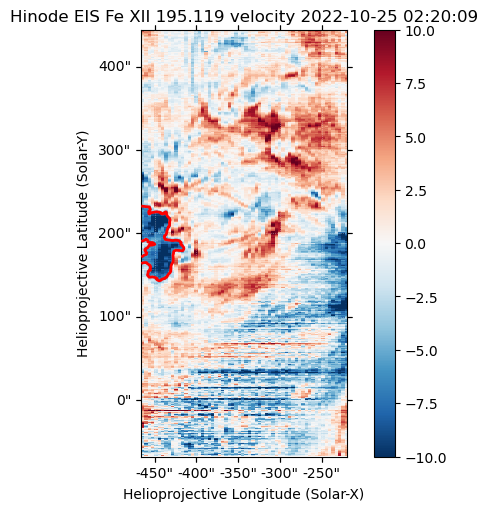

In [36]:
cs_selected_index = [20,23]
    
fig = plt.figure(figsize=(7, 5),layout='constrained')
ax = fig.add_subplot(111, projection=eis_FeXII_195_velmap)
eis_FeXII_195_velmap.plot(axes=ax)
plt.colorbar()

for ii in cs_selected_index:
    ax.plot(*cs.allsegs[0][ii].T, color='red', lw=2)

In [37]:
cs_skycoords = [eis_FeXII_195_velmap.pixel_to_world(np.concatenate((cs.allsegs[0][cs_selected_index[0]][:,0],
                                                                    cs.allsegs[0][cs_selected_index[1]][:,0]))*u.pix,
                                                    np.concatenate((cs.allsegs[0][cs_selected_index[0]][:,1],
                                                                    cs.allsegs[0][cs_selected_index[1]][:,1]))*u.pix) \
                ]
cs_regions = [PolygonSkyRegion(vertices=cs_skycoord) for cs_skycoord in cs_skycoords]

In [38]:
coronal_hole_ref_region_center=SkyCoord(-330*u.arcsec, 30*u.arcsec, frame=eis_FeXII_195_intmap.coordinate_frame)
eis_FeXII_195_intmap_coronal_hole_pixel_region = EllipsePixelRegion(center=PixCoord.from_sky(coronal_hole_ref_region_center, eis_FeXII_195_intmap.wcs),
                                            width=(60*u.arcsec/eis_FeXII_195_intmap.scale.axis1).to_value(u.pix), 
                                            height=(60*u.arcsec/eis_FeXII_195_intmap.scale.axis2).to_value(u.pix))

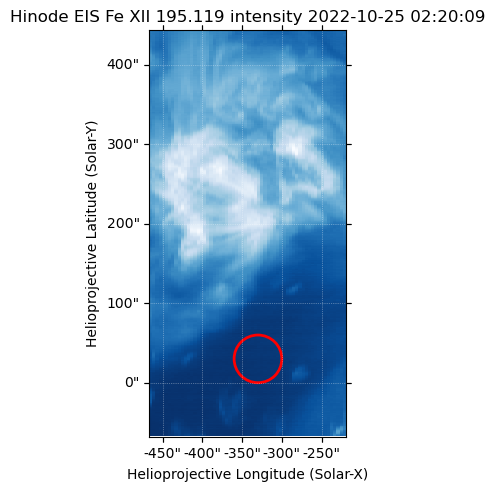

In [39]:
fig = plt.figure(layout='constrained')

ax = fig.add_subplot(111, projection=eis_FeXII_195_intmap)
eis_FeXII_195_intmap.plot(axes=ax)

eis_FeXII_195_intmap_coronal_hole_pixel_region.plot(ax=ax, edgecolor='red', lw=2)

In [40]:
coronal_hole_ref_region_params = {'center':coronal_hole_ref_region_center, 'width':60*u.arcsec, 'height':60*u.arcsec}

In [41]:
def get_sky_region_centroid(sky_region, wcs):
    pixel_region = sky_region.to_pixel(wcs)
    pixel_region_shapely = shapely.geometry.Polygon(np.vstack(pixel_region.vertices.xy).T)
    pixel_region_shapely_centroid = pixel_region_shapely.centroid
    sky_coord_centroid = wcs.pixel_to_world(pixel_region_shapely_centroid.x, pixel_region_shapely_centroid.y)

    return sky_coord_centroid

In [42]:
FeXII_195_sr_stray_light, FeXII_195_sr_stray_light_region = calc_short_range_stray_light(eis_FeXII_195_intmap,
                                                                                        get_sky_region_centroid(cs_regions[0], eis_FeXII_195_intmap.wcs),
                                                                                        return_region=True)

Short range stray light: 81.65


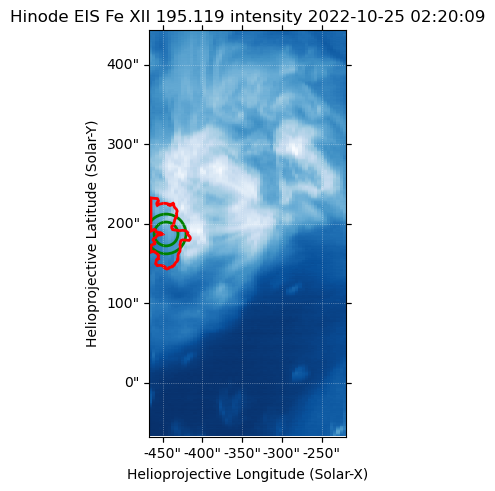

In [43]:
fig = plt.figure(layout='constrained')

ax = fig.add_subplot(111, projection=eis_FeXII_195_intmap)
eis_FeXII_195_intmap.plot(axes=ax)

FeXII_195_sr_stray_light_region.plot(ax=ax, edgecolor='green', lw=2)
cs_regions[0].to_pixel(eis_FeXII_195_intmap.wcs).plot(ax=ax, edgecolor='red', lw=2)

print(f'Short range stray light: {FeXII_195_sr_stray_light:.2f}')

In [44]:
FeXII_lr_stray_light, FeXII_lr_stray_light_coalign_region, _ = calc_long_range_stray_light_aia_eis(eis_FeXII_195_intmap, aia_193_map,
                                                           SkyCoord(-440*u.arcsec, 100*u.arcsec, frame=eis_FeXII_195_intmap.coordinate_frame),
                                                           region_radius = 50*u.arcsec, return_region=True)

Long range stray light: 14.27


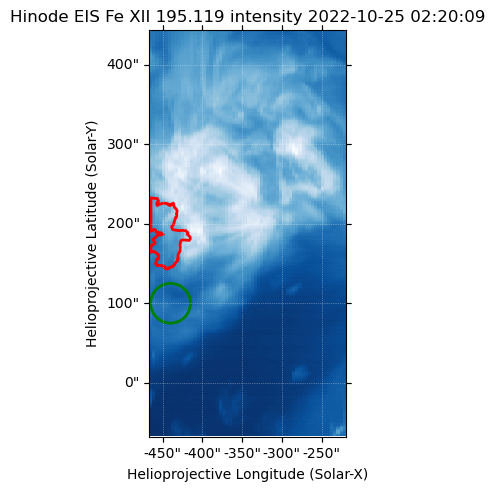

In [45]:
fig = plt.figure(layout='constrained')

ax = fig.add_subplot(111, projection=eis_FeXII_195_intmap)
eis_FeXII_195_intmap.plot(axes=ax)

FeXII_lr_stray_light_coalign_region.plot(ax=ax, edgecolor='green', lw=2)
cs_regions[0].to_pixel(eis_FeXII_195_intmap.wcs).plot(ax=ax, edgecolor='red', lw=2)

print(f'Long range stray light: {FeXII_lr_stray_light:.2f}')

In [46]:
def get_intensity_from_cs_regions(intensity_map, cs_regions):
    intensity = []
    masks = [np.where(cs_region.contains(sunpy.map.all_coordinates_from_map(intensity_map), 
                                                intensity_map.wcs)) for cs_region in cs_regions]
    intensity = [intensity_map.data[mask_] for mask_ in masks]
    return intensity

In [47]:
def mean_intensity_in_region(regions_intensity, min=None, max=None):
    if max is not None:
        for region_intensity in regions_intensity:
            mask = np.where(region_intensity > max)
            region_intensity[mask] = np.nan
    if min is not None:
        for region_intensity in regions_intensity:
            mask = np.where(region_intensity < min)
            region_intensity[mask] = np.nan
    return np.array([np.nanmean(region_intensity) for region_intensity in regions_intensity])

In [48]:
eis_radcal_file = readsav('../../sav/eis_radcal_20221025.sav',verbose=True)

--------------------------------------------------
Date: Thu Jun 27 11:54:26 2024
User: yjzhu
Host: NB-RES-YINGJIE
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.8.3
--------------------------------------------------
Successfully read 11 records of which:
 - 1 are of type TIMESTAMP
 - 8 are of type VARIABLE
 - 1 are of type VERSION
--------------------------------------------------
Available variables:
 - sw_wvl [<class 'numpy.ndarray'>]
 - lw_wvl [<class 'numpy.ndarray'>]
 - gdz_sw [<class 'numpy.ndarray'>]
 - gdz_lw [<class 'numpy.ndarray'>]
 - hpw_sw [<class 'numpy.ndarray'>]
 - hpw_lw [<class 'numpy.ndarray'>]
 - new_sw [<class 'numpy.ndarray'>]
 - new_lw [<class 'numpy.ndarray'>]
--------------------------------------------------


In [49]:
def get_eis_radcal(wvl,radcal_file=eis_radcal_file,method='hpw'):
    if isinstance(wvl, u.Quantity):
        wvl = wvl.to_value(u.angstrom)
        
    if method == 'hpw':
        lw_radcal = radcal_file['hpw_lw']
        sw_radcal = radcal_file['hpw_sw']
    elif method == 'lpw':
        lw_radcal = radcal_file['lpw_lw']
        sw_radcal = radcal_file['lpw_sw']
    elif method == 'new':
        lw_radcal = radcal_file['new_lw']
        sw_radcal = radcal_file['new_sw']
    
    if 165 < wvl < 212:
        radcal = sw_radcal
        wvl_grid = radcal_file['sw_wvl']
    elif 245 < wvl < 292:
        radcal = lw_radcal
        wvl_grid = radcal_file['lw_wvl']
    else:
        raise ValueError('Wavelength out of range')
    
    radcal_interp_func = scipy.interpolate.interp1d(wvl_grid, radcal, kind='cubic', fill_value='extrapolate')
    return radcal_interp_func(wvl)

In [50]:
def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14,
                  bbox_to_anchor=(1.02, 0., 1, 1),orientation="vertical"):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=bbox_to_anchor,
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

In [51]:
def read_eis_fit_and_return_upflow_int(eis_file_prefix, eis_line_name,cs_regions,
                                       component=0, radcal_file=eis_radcal_file, method='hpw',
                                       int_hist=0, min=None, max=None, reference_region_params=None,
                                       short_range_stray_light=False, long_range_stray_light=False,
                                       long_range_stray_light_aia_ref=None, 
                                       long_range_stray_light_ref_center=None,
                                       long_range_stray_light_ref_radius=None,
                                       eis_aia_shift = (Txshift_aia_eis_rough, Tyshift_aia_eis_rough),
                                       eis_chi2_mask_threshold=50,
                                       short_range_stray_light_corr_ratio=1.):
    
    eis_fitres = eispac.read_fit(eis_file_prefix + eis_line_name + '.fit.h5')
    eis_intmap = eis_fitres.get_map(component=component, measurement='intensity')

    if eis_chi2_mask_threshold is not None and eis_chi2_mask_threshold > 0:
        chi2_mask = np.where(eis_fitres.fit['chi2'] > eis_chi2_mask_threshold)
        eis_intdata = eis_intmap.data.copy()
        eis_intdata[chi2_mask] = np.nan
        eis_intmap = sunpy.map.Map(eis_intdata, eis_intmap.meta)
        
    if eis_aia_shift is not None:
        eis_intmap = eis_intmap.shift_reference_coord(*eis_aia_shift)
    eis_intmap.plot_settings['norm'] = ImageNormalize(vmin=np.nanpercentile(eis_intmap.data, 0.5),
                                                      vmax=np.nanpercentile(eis_intmap.data, 99.5),
                                                      stretch=AsinhStretch(0.1))
    eis_intmap.plot_settings['cmap'] = 'plasma'

    eis_regions_int = get_intensity_from_cs_regions(eis_intmap, cs_regions)
    eis_regions_int_mean = mean_intensity_in_region(eis_regions_int, min=min, max=max)
    eis_radcal_factor = get_eis_radcal(eis_intmap.wavelength, radcal_file=radcal_file, method=method)
    eis_regions_int_mean_radcal = eis_regions_int_mean*eis_radcal_factor
    
    fig = plt.figure(figsize=(7, 5),layout='constrained')
    ax = fig.add_subplot(111, projection=eis_intmap)
    eis_intmap.plot(axes=ax)
    
    for ii, region in enumerate(cs_regions):
        ax.plot_coord(region.vertices, color='red', lw=2, label='Upflow Region' if ii == 0 else '')
    
    if reference_region_params is not None:
        referene_circle_pixel_region = EllipsePixelRegion(center=PixCoord.from_sky(reference_region_params['center'], eis_intmap.wcs),
                                            width=(reference_region_params['width']/eis_intmap.scale.axis1).to_value(u.pix), 
                                            height=(reference_region_params['height']/eis_intmap.scale.axis2).to_value(u.pix))
        referene_circle_pixel_region.plot(ax=ax, edgecolor='blue', lw=2, label='CH Ref. Region')

    if short_range_stray_light or long_range_stray_light:
        stray_light_int = np.zeros((len(cs_regions),2))
        sr_stray_light_regions = []
        if short_range_stray_light is True:
            for ii, region in enumerate(cs_regions):
                sr_stray_light, sr_stray_light_region = calc_short_range_stray_light(eis_intmap,
                                                                                    get_sky_region_centroid(region, eis_intmap.wcs),
                                                                                    return_region=True)
                stray_light_int[ii,0] = sr_stray_light*short_range_stray_light_corr_ratio
                sr_stray_light_regions.append(sr_stray_light_region)

        if long_range_stray_light is True:
            lr_stray_light, lr_stray_light_coalign_region, lr_stray_light_aia_region = \
                            calc_long_range_stray_light_aia_eis(eis_intmap, long_range_stray_light_aia_ref,
                            SkyCoord(*long_range_stray_light_ref_center, frame=eis_intmap.coordinate_frame),
                            region_radius = long_range_stray_light_ref_radius,
                            return_region=True)
            
            lr_stray_light_coalign_region.plot(ax=ax, edgecolor='yellow', lw=2, label='LRSL Ref. Region')
            stray_light_int[:,1] = lr_stray_light

            aia_map_crop = long_range_stray_light_aia_ref.submap(eis_intmap.bottom_left_coord, top_right=eis_intmap.top_right_coord)
            fig_aia = plt.figure(figsize=(7, 5),layout='constrained')
            ax_aia = fig_aia.add_subplot(111, projection=aia_map_crop)
            aia_map_crop.plot(axes=ax_aia)
            lr_stray_light_aia_region.to_sky(long_range_stray_light_aia_ref.wcs).to_pixel(aia_map_crop.wcs).plot(ax=ax_aia, edgecolor='yellow', lw=2, label='LRSL AIA Ref. Region')
            
    if int_hist is not False:
        if isinstance(int_hist, int) and (0 <= int_hist < len(cs_regions)):
            fig_hist, ax_hist = plt.subplots(layout='constrained')
            ax_hist.hist(eis_regions_int[int_hist], bins=10, histtype='step', color='red', lw=2, 
                    range=(np.nanmin(eis_regions_int[int_hist]),np.nanmax(eis_regions_int[int_hist])),
                    label='Region ' + str(int_hist), weights=np.ones_like(eis_regions_int[int_hist])/len(eis_regions_int[int_hist]))
            
            if min is not None:
                ax_hist.axvline(min, color='red', lw=2, ls='--')
            if max is not None:
                ax_hist.axvline(max, color='red', lw=2, ls='--')
        
        if reference_region_params is not None:
            reference_region_mask = np.where(referene_circle_pixel_region.contains(PixCoord.from_sky(sunpy.map.all_coordinates_from_map(eis_intmap),
                                                                                                     eis_intmap.wcs)))
            ax_hist.hist(eis_intmap.data[reference_region_mask], bins=10, histtype='step', color='blue', lw=2, 
                    range=(np.nanmin(eis_intmap.data[reference_region_mask]),np.nanmax(eis_intmap.data[reference_region_mask])),
                    label='Reference Region', weights=np.ones_like(eis_intmap.data[reference_region_mask])/len(eis_intmap.data[reference_region_mask]))
            
        if short_range_stray_light is True:
            ax_hist.axvline(stray_light_int[int_hist,0], color='green', lw=2, ls='--', label='SR Stray Light')
            sr_stray_light_regions[int_hist].plot(ax=ax, edgecolor='green', lw=2, label='SRSL Region')

        if long_range_stray_light is True:
            ax_hist.axvline(stray_light_int[int_hist,1], color='yellow', lw=2, ls='--', label='LR Stray Light')

        if short_range_stray_light is True and long_range_stray_light is True:
            ax_hist.axvline(np.sum(stray_light_int[int_hist,:]), color='purple', lw=2, ls='--', label='Total Stray Light')
        
        ax_hist.legend(loc='upper right')
        ax_hist.set_xlabel(r'Pre-flight Intensity [erg cm$^{-2}$ s$^{-1}$ sr$^{-1}$]')

    
        ax_leg = ax.legend(bbox_to_anchor=(1.4, 0.7, 0.5, 0.3))
        leg_box = ax_leg.get_window_extent(renderer=fig.canvas.get_renderer())
        leg_box_ax_coords = leg_box.transformed(ax.transAxes.inverted())

        plot_colorbar(ax.images[0],ax,width='5%',bbox_to_anchor=(1.07, 0., 1, leg_box_ax_coords.y0 - 0.05),fontsize=12)

    if short_range_stray_light is True or long_range_stray_light is True:
        return eis_regions_int_mean_radcal, stray_light_int*eis_radcal_factor
    else:
        return eis_regions_int_mean_radcal

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_08_185_213.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_81952/3029816634.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 700x500 with 2 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)


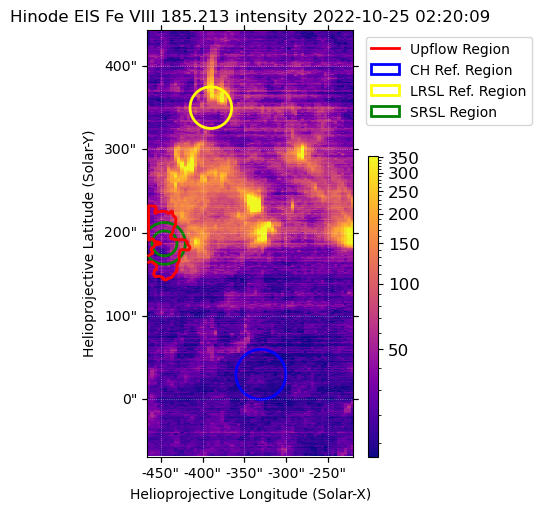

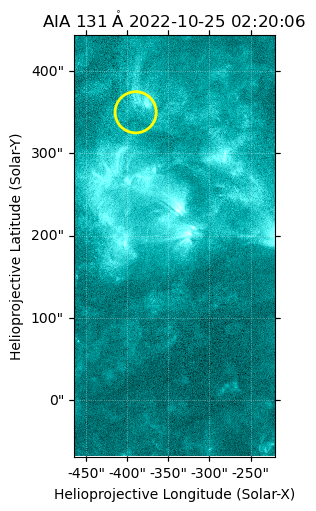

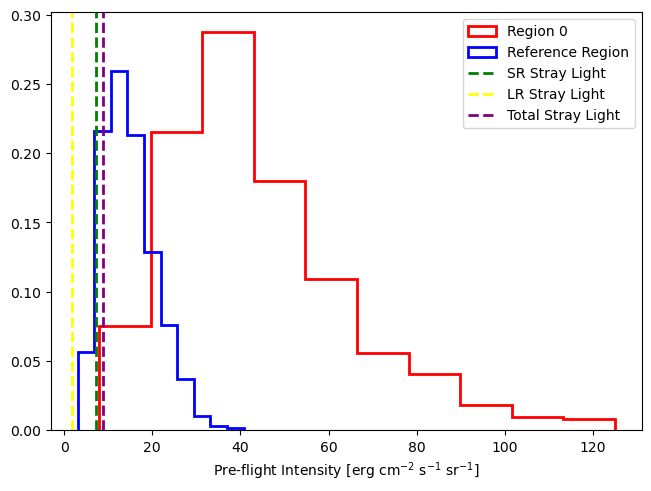

In [52]:
eis_FeVIII_185_upflow_regions_int_mean_radcal, \
eis_FeVIII_185_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_08_185_213.1c-0', cs_regions,
                                                                                   reference_region_params=coronal_hole_ref_region_params,
                                                                                   short_range_stray_light=True, 
                                                                                   long_range_stray_light=True,
                                                                                   long_range_stray_light_aia_ref=aia_131_map,
                                                                                   long_range_stray_light_ref_center=[-390,350]*u.arcsec,
                                                                                   long_range_stray_light_ref_radius=50*u.arcsec)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_08_186_601.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_81952/3029816634.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 700x500 with 2 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)


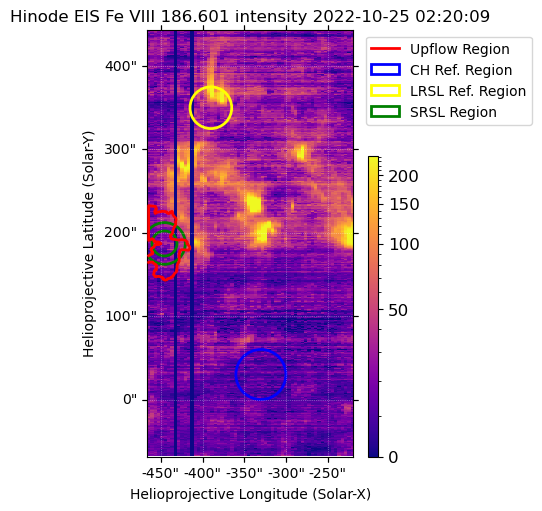

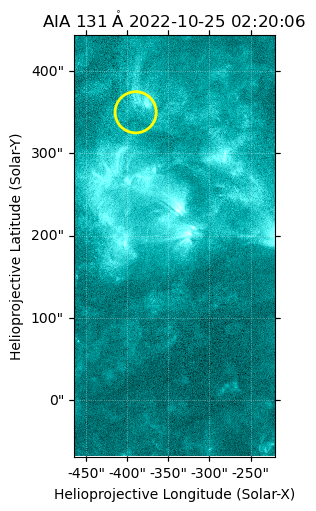

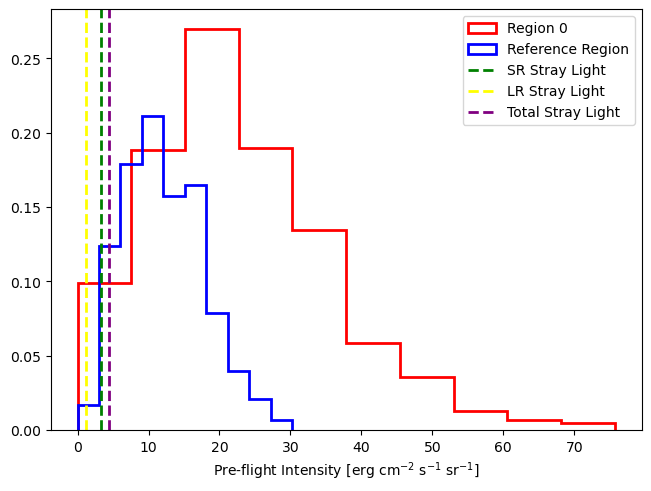

In [53]:
eis_FeVIII_186_upflow_regions_int_mean_radcal, \
eis_FeVIII_186_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_08_186_601.1c-0', cs_regions,
                                                                                   reference_region_params=coronal_hole_ref_region_params,
                                                                                   short_range_stray_light=True,
                                                                                   long_range_stray_light=True,
                                                                                   long_range_stray_light_aia_ref=aia_131_map,
                                                                                   long_range_stray_light_ref_center=[-390,350]*u.arcsec,
                                                                                   long_range_stray_light_ref_radius=50*u.arcsec)


Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_09_188_497.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_81952/3029816634.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 700x500 with 2 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)


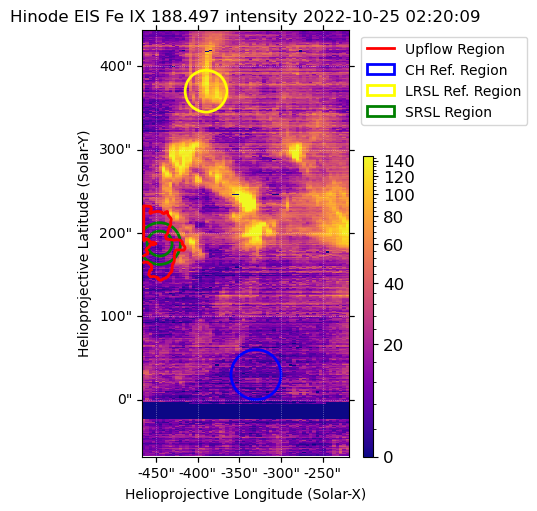

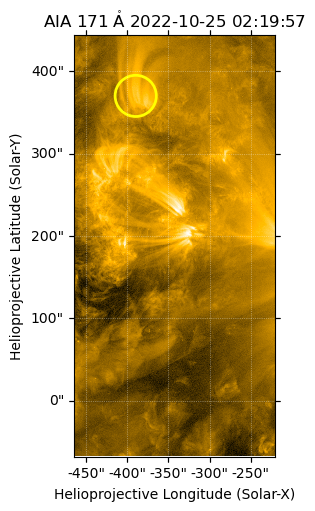

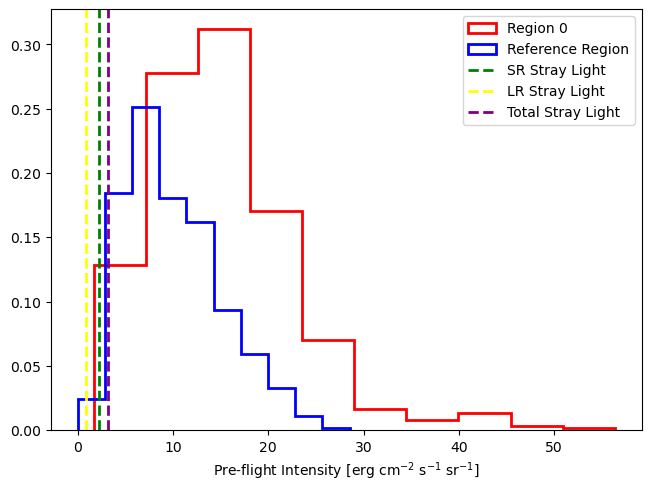

In [54]:
eis_FeIX_188_upflow_regions_int_mean_radcal, \
eis_FeIX_188_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_09_188_497.1c-0', cs_regions,
                                                                                 reference_region_params=coronal_hole_ref_region_params,
                                                                                 short_range_stray_light=True,
                                                                                 long_range_stray_light=True,
                                                                                 long_range_stray_light_aia_ref=aia_171_map,
                                                                                 long_range_stray_light_ref_center=[-390,370]*u.arcsec,
                                                                                 long_range_stray_light_ref_radius=50*u.arcsec)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_09_197_862.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_81952/3029816634.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 700x500 with 2 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)


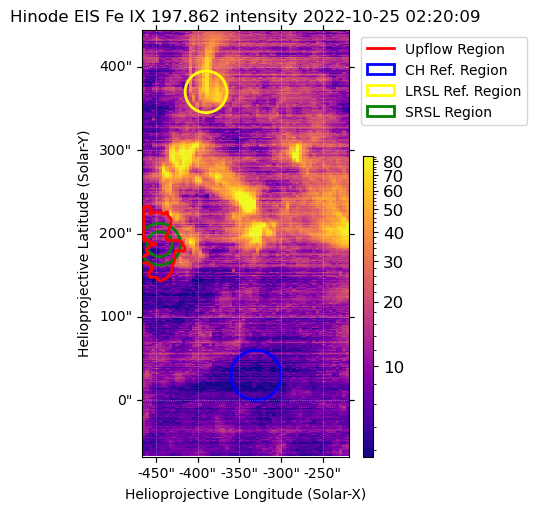

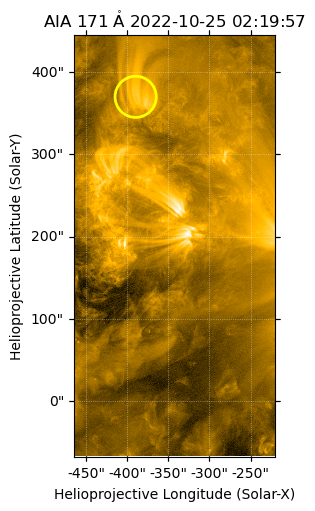

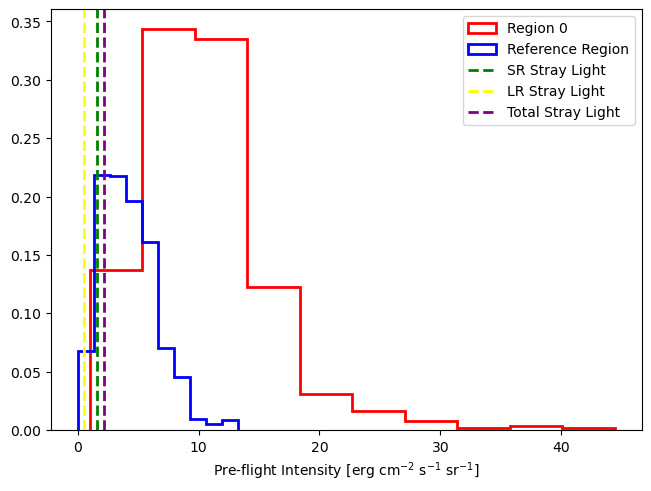

In [55]:
eis_FeIX_197_upflow_regions_int_mean_radcal, \
eis_FeIX_197_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_09_197_862.1c-0', cs_regions,
                                                                                 reference_region_params=coronal_hole_ref_region_params,
                                                                                 short_range_stray_light=True,
                                                                                 long_range_stray_light=True,
                                                                                 long_range_stray_light_aia_ref=aia_171_map,
                                                                                 long_range_stray_light_ref_center=[-390,370]*u.arcsec,
                                                                                 long_range_stray_light_ref_radius=50*u.arcsec)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_10_184_536.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_81952/3029816634.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 700x500 with 2 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)


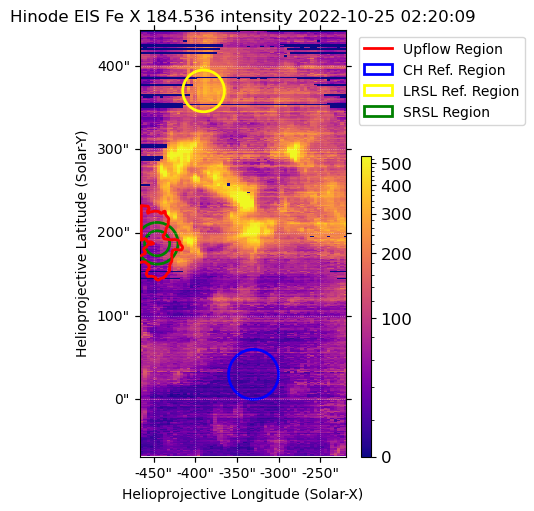

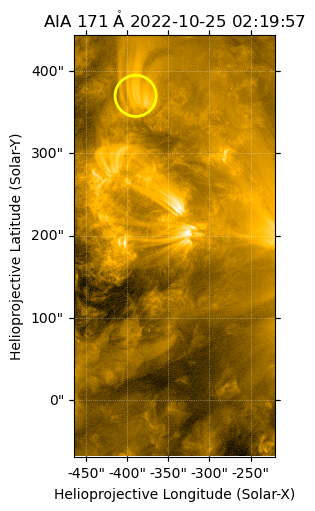

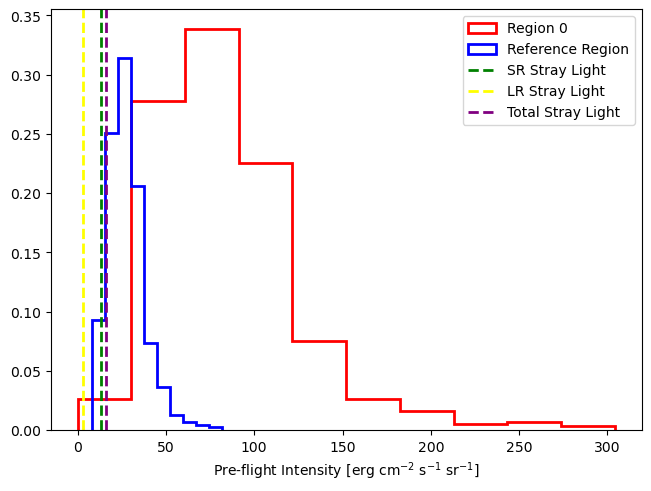

In [56]:
eis_FeX_184_upflow_regions_int_mean_radcal, \
eis_FeX_184_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_10_184_536.1c-0', cs_regions,
                                                                                reference_region_params=coronal_hole_ref_region_params,
                                                                                short_range_stray_light=True,
                                                                                long_range_stray_light=True,
                                                                                long_range_stray_light_aia_ref=aia_171_map,
                                                                                long_range_stray_light_ref_center=[-390,370]*u.arcsec,
                                                                                long_range_stray_light_ref_radius=50*u.arcsec)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_11_188_216.2c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_81952/3029816634.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 700x500 with 2 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)


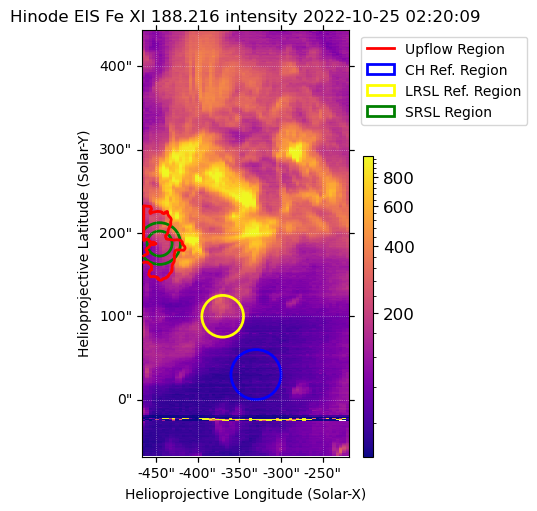

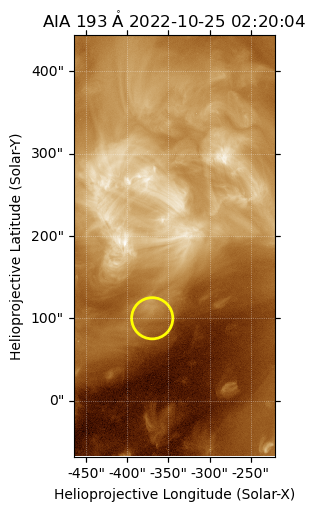

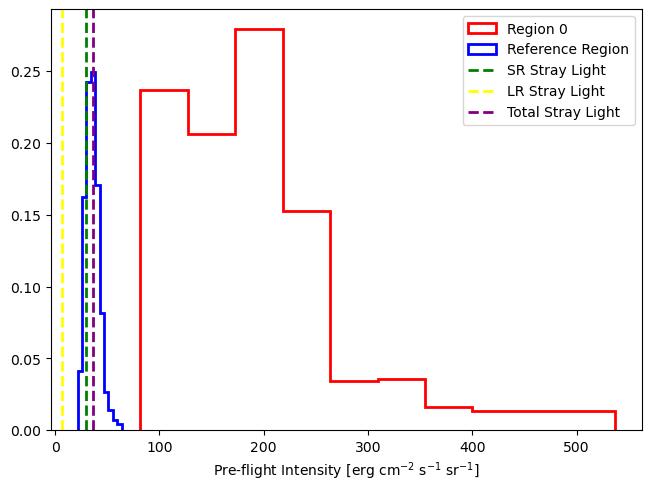

In [57]:
eis_FeXI_188_216_upflow_regions_int_mean_radcal, \
eis_FeXI_188_216_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_11_188_216.2c-0', cs_regions,
                                                                                     reference_region_params=coronal_hole_ref_region_params,
                                                                                     short_range_stray_light=True,
                                                                                     long_range_stray_light=True,
                                                                                     long_range_stray_light_aia_ref=aia_193_map,
                                                                                     long_range_stray_light_ref_center=[-370,100]*u.arcsec,
                                                                                     long_range_stray_light_ref_radius=50*u.arcsec)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_11_188_299.2c-1.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_81952/3029816634.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 700x500 with 2 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)


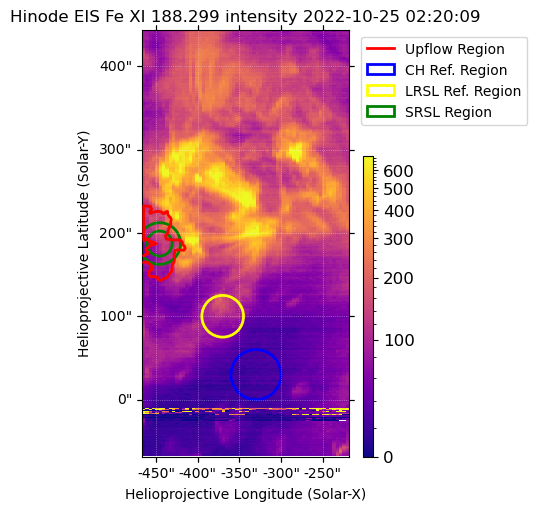

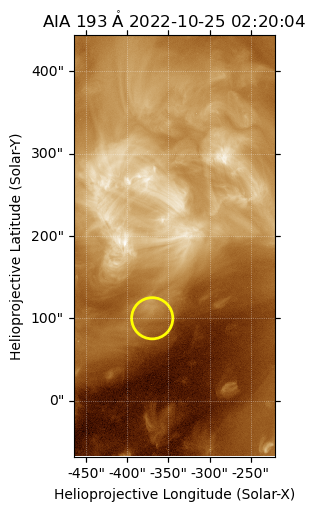

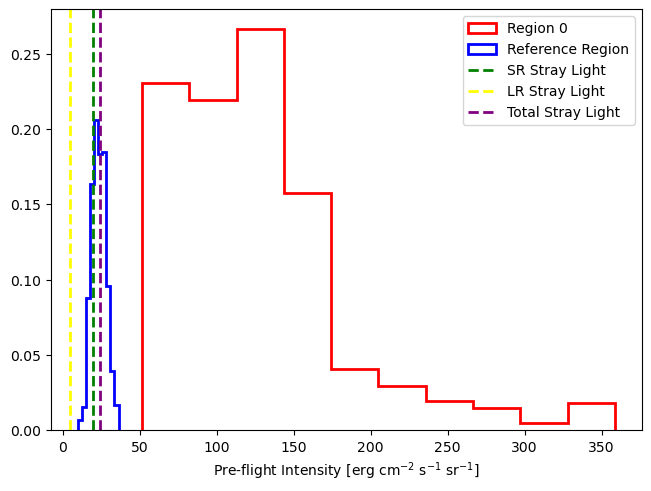

In [58]:
eis_FeXI_188_299_upflow_regions_int_mean_radcal, \
eis_FeXI_188_299_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_11_188_299.2c-1', cs_regions,
                                                                                     component=1, reference_region_params=coronal_hole_ref_region_params,
                                                                                     short_range_stray_light=True,
                                                                                     long_range_stray_light=True,
                                                                                     long_range_stray_light_aia_ref=aia_193_map,
                                                                                     long_range_stray_light_ref_center=[-370,100]*u.arcsec,
                                                                                     long_range_stray_light_ref_radius=50*u.arcsec)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_12_192_394.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_81952/3029816634.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 700x500 with 2 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)


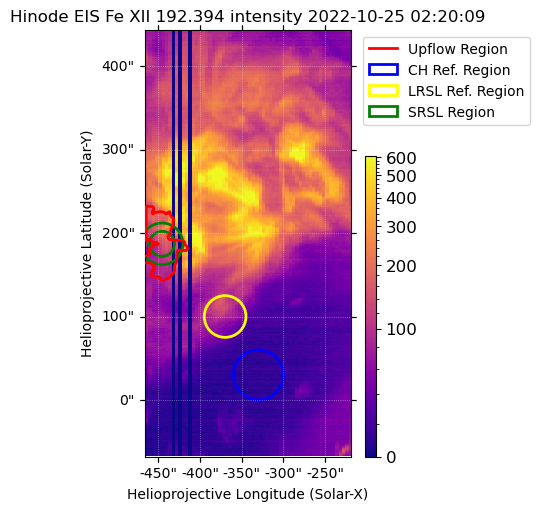

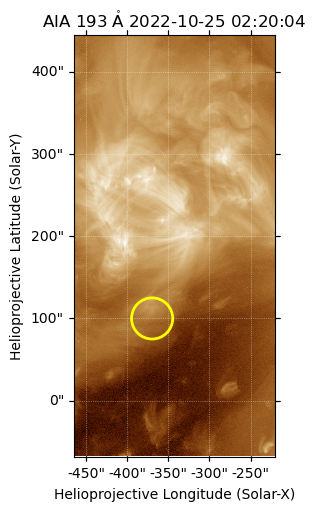

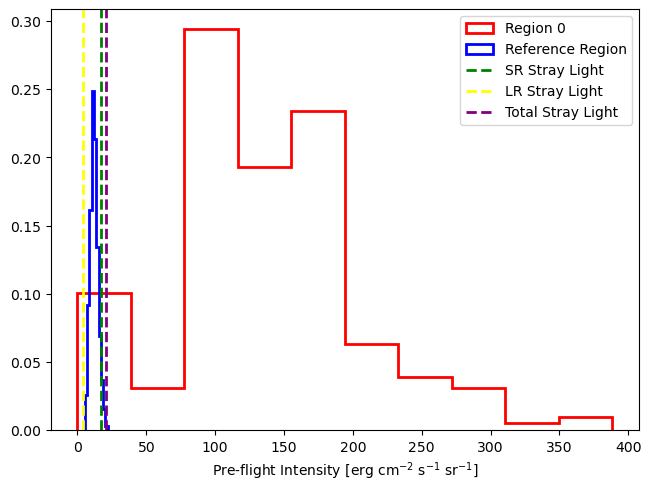

In [59]:
eis_FeXII_192_upflow_regions_int_mean_radcal, \
eis_FeXII_192_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_12_192_394.1c-0', cs_regions,
                                                                                  reference_region_params=coronal_hole_ref_region_params,
                                                                                  short_range_stray_light=True,
                                                                                  long_range_stray_light=True,
                                                                                  long_range_stray_light_aia_ref=aia_193_map,
                                                                                  long_range_stray_light_ref_center=[-370,100]*u.arcsec,
                                                                                  long_range_stray_light_ref_radius=50*u.arcsec)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_12_195_119.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_81952/3029816634.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 700x500 with 2 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)


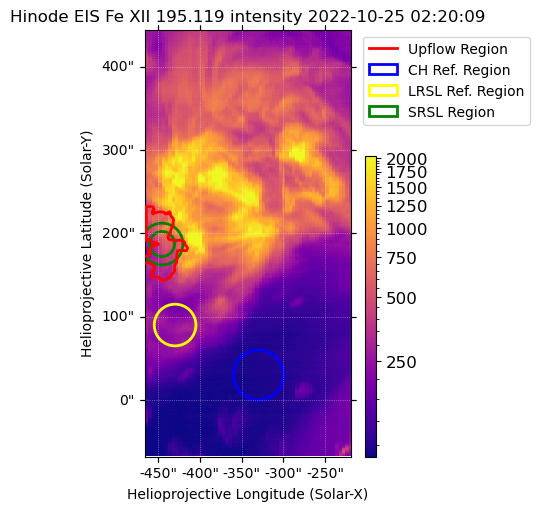

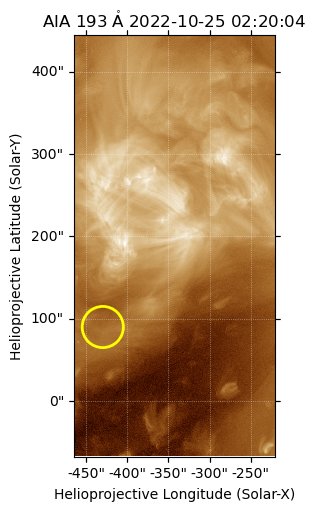

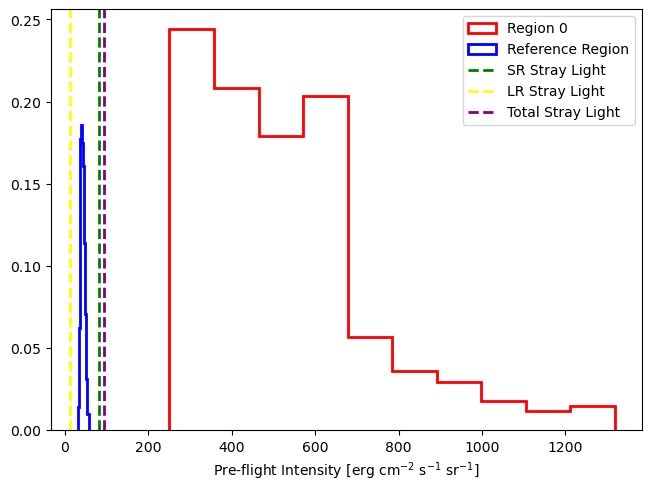

In [60]:
eis_FeXII_195_upflow_regions_int_mean_radcal, \
eis_FeXII_195_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_12_195_119.1c-0', cs_regions,
                                                                                    reference_region_params=coronal_hole_ref_region_params,
                                                                                    short_range_stray_light=True,
                                                                                    long_range_stray_light=True,
                                                                                    long_range_stray_light_aia_ref=aia_193_map,
                                                                                    long_range_stray_light_ref_center=[-430,90]*u.arcsec,
                                                                                    long_range_stray_light_ref_radius=50*u.arcsec)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_13_202_044.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_81952/3029816634.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 700x500 with 2 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)


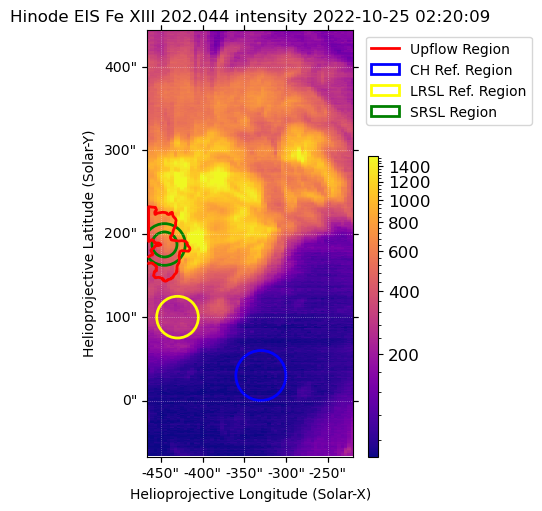

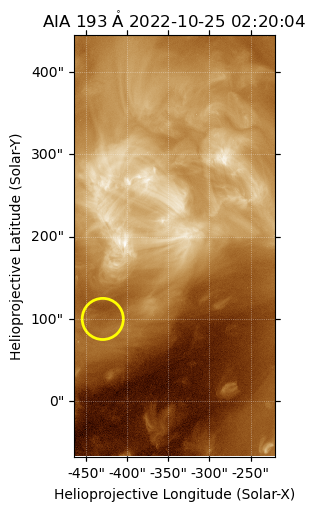

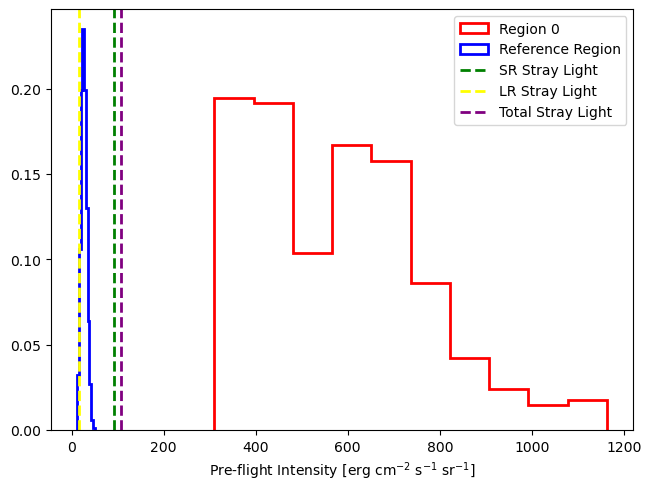

In [61]:
eis_FeXIII_202_upflow_regions_int_mean_radcal, \
eis_FeXIII_202_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_13_202_044.1c-0', cs_regions,
                                                                                   reference_region_params=coronal_hole_ref_region_params,
                                                                                   short_range_stray_light=True,
                                                                                   long_range_stray_light=True,
                                                                                   long_range_stray_light_aia_ref=aia_193_map,
                                                                                   long_range_stray_light_ref_center=[-430,100]*u.arcsec,
                                                                                   long_range_stray_light_ref_radius=50*u.arcsec)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_12_203_720.2c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_81952/3029816634.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 700x500 with 2 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)


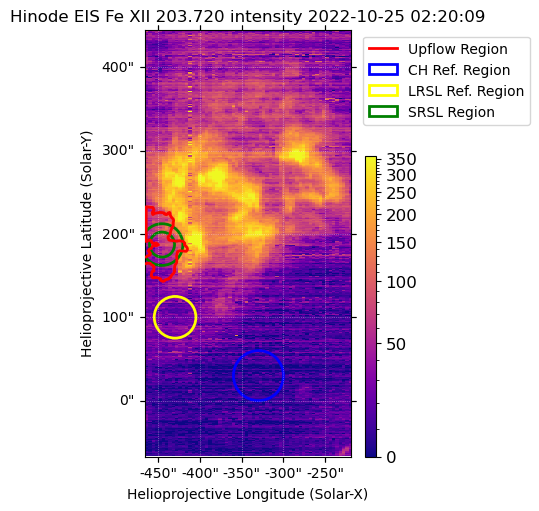

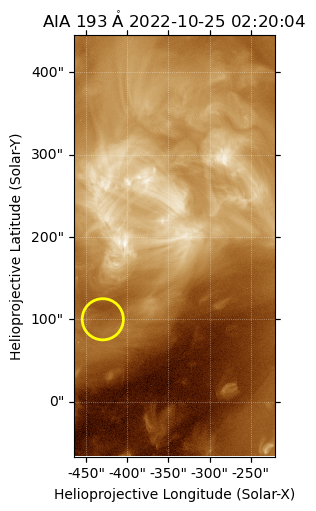

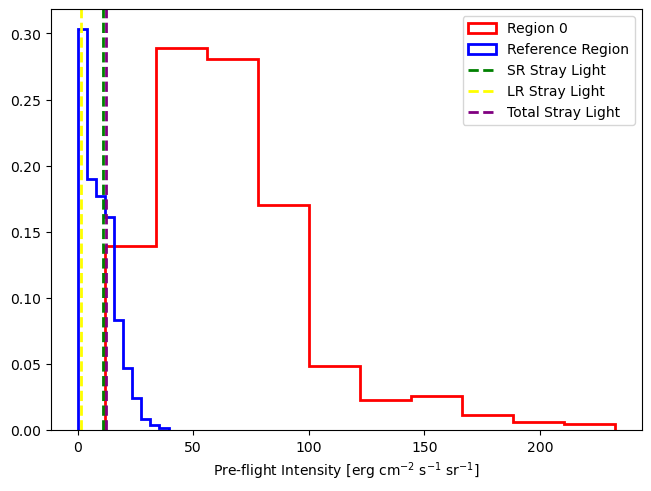

In [62]:
eis_FeXII_203_720_upflow_regions_int_mean_radcal, \
eis_FeXII_203_720_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_12_203_720.2c-0', cs_regions,
                                                                                      reference_region_params=coronal_hole_ref_region_params,
                                                                                      short_range_stray_light=True,
                                                                                      long_range_stray_light=True,
                                                                                      long_range_stray_light_aia_ref=aia_193_map,
                                                                                      long_range_stray_light_ref_center=[-430,100]*u.arcsec,
                                                                                      long_range_stray_light_ref_radius=50*u.arcsec)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_13_203_826.2c-1.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_81952/3029816634.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 700x500 with 2 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)


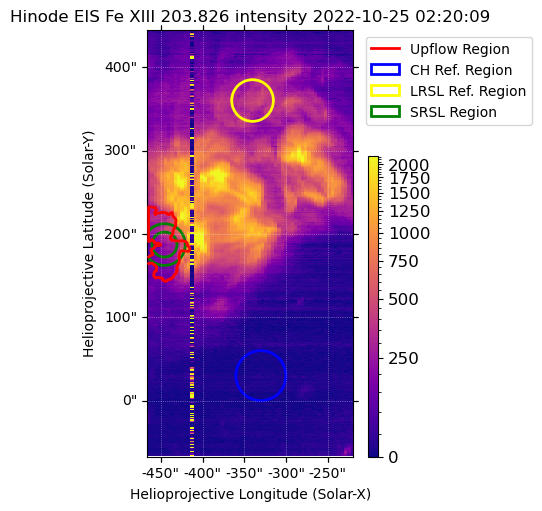

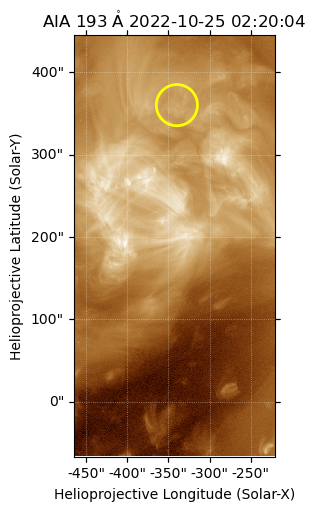

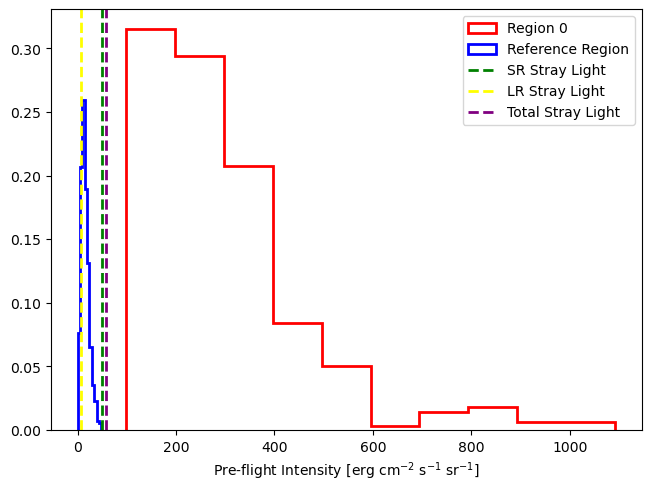

In [63]:
eis_FeXIII_203_826_upflow_regions_int_mean_radcal, \
eis_FeXIII_203_826_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_13_203_826.2c-1', cs_regions,
                                                                                       component=1, reference_region_params=coronal_hole_ref_region_params,
                                                                                       short_range_stray_light=True,
                                                                                       long_range_stray_light=True,
                                                                                       long_range_stray_light_aia_ref=aia_193_map,
                                                                                        long_range_stray_light_ref_center=[-340,360]*u.arcsec,
                                                                                        long_range_stray_light_ref_radius=50*u.arcsec)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_14_264_787.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_81952/3029816634.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 700x500 with 2 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)


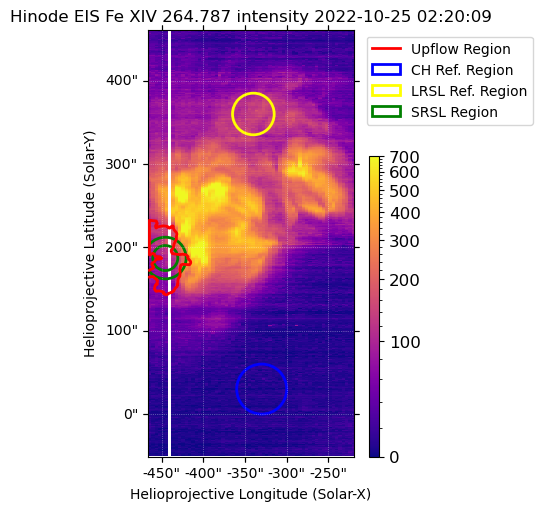

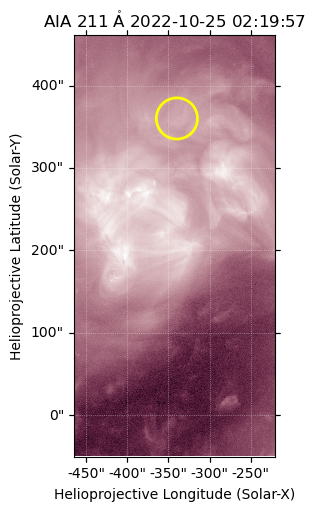

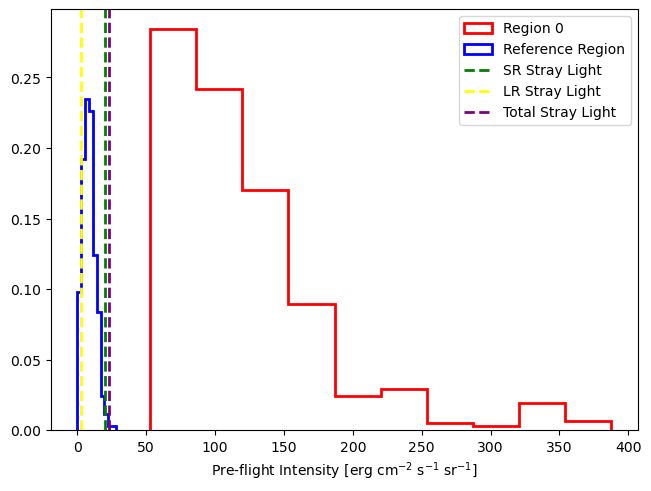

In [64]:
eis_FeXIV_264_upflow_regions_int_mean_radcal, \
eis_FeXIV_264_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_14_264_787.1c-0', cs_regions,
                                                                                  int_hist=0,
                                                                                  reference_region_params=coronal_hole_ref_region_params,
                                                                                  short_range_stray_light=True,
                                                                                  long_range_stray_light=True,
                                                                                  long_range_stray_light_aia_ref=aia_211_map,
                                                                                  long_range_stray_light_ref_center=[-340,360]*u.arcsec,
                                                                                  long_range_stray_light_ref_radius=50*u.arcsec)


Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_14_270_519.2c-1.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_81952/3029816634.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 700x500 with 2 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)


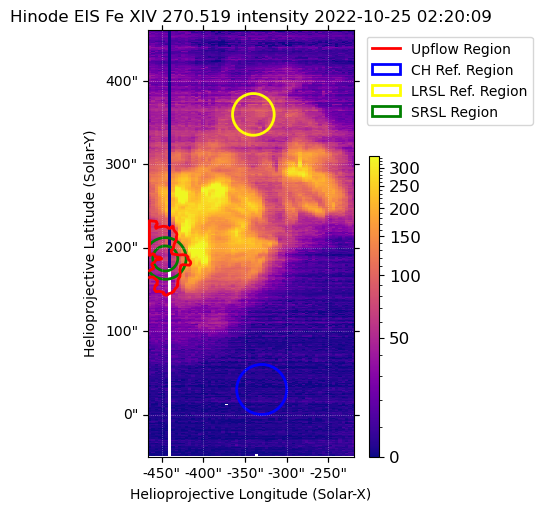

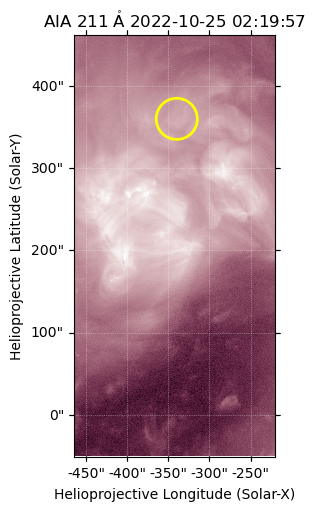

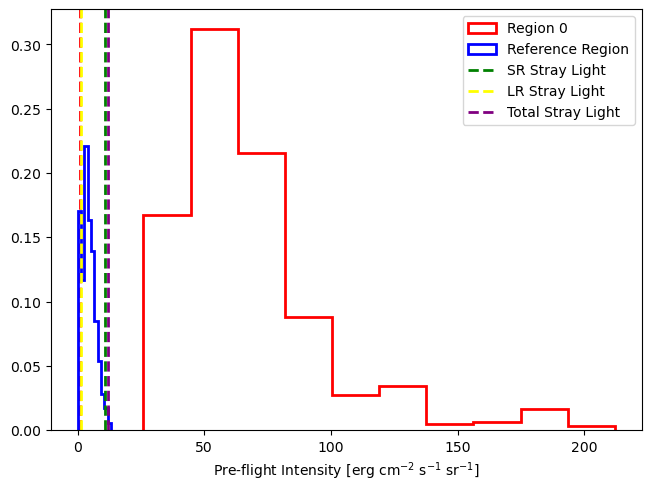

In [65]:
eis_FeXIV_270_upflow_regions_int_mean_radcal, \
eis_FeXIV_270_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_14_270_519.2c-1', cs_regions,
                                                                                  component=1,int_hist=0, min=1,
                                                                                  reference_region_params=coronal_hole_ref_region_params,
                                                                                  short_range_stray_light=True,
                                                                                  long_range_stray_light=True,
                                                                                  long_range_stray_light_aia_ref=aia_211_map,
                                                                                  long_range_stray_light_ref_center=[-340,360]*u.arcsec,
                                                                                  long_range_stray_light_ref_radius=50*u.arcsec,
                                                                                  eis_chi2_mask_threshold=10)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_15_284_160.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_81952/3029816634.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 700x500 with 2 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)


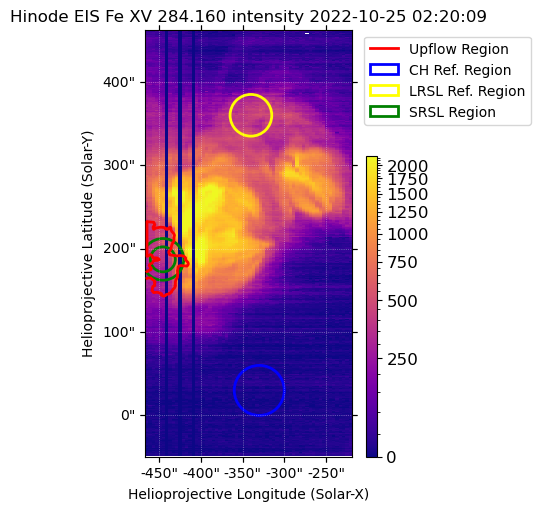

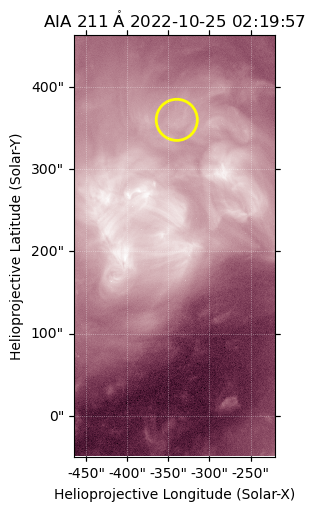

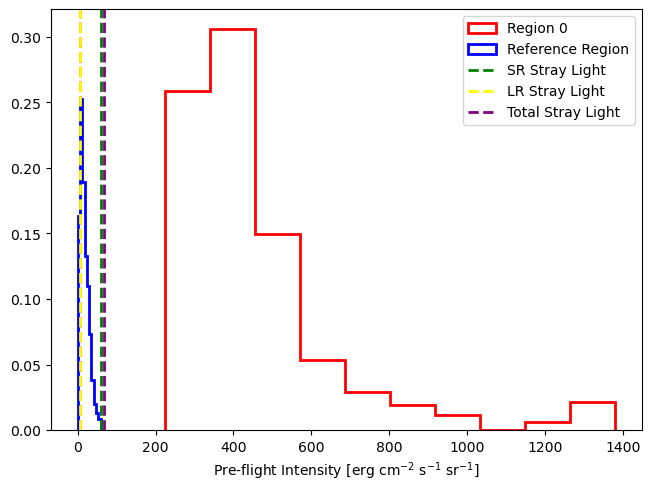

In [66]:
eis_FeXV_284_upflow_regions_int_mean_radcal, \
eis_FeXV_284_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_15_284_160.1c-0', cs_regions,
                                                                                 int_hist=0, min = 5,
                                                                                 reference_region_params=coronal_hole_ref_region_params,
                                                                                 short_range_stray_light=True,
                                                                                 long_range_stray_light=True,
                                                                                 long_range_stray_light_aia_ref=aia_211_map,
                                                                                 long_range_stray_light_ref_center=[-340,360]*u.arcsec,
                                                                                 long_range_stray_light_ref_radius=50*u.arcsec,
                                                                                 eis_chi2_mask_threshold=10)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.fe_16_262_984.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_81952/3029816634.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 700x500 with 2 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)


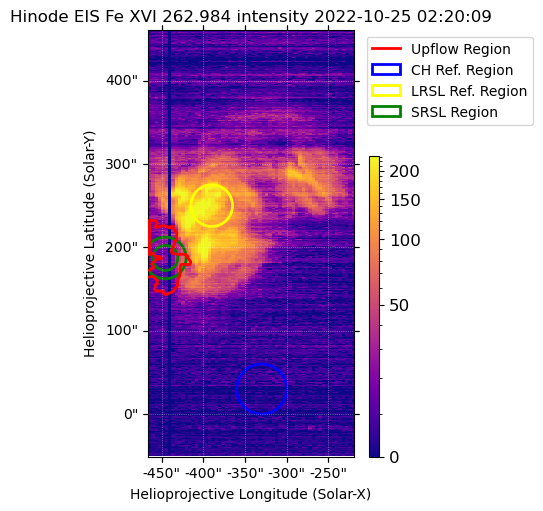

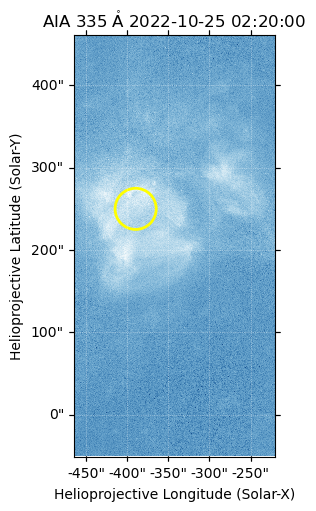

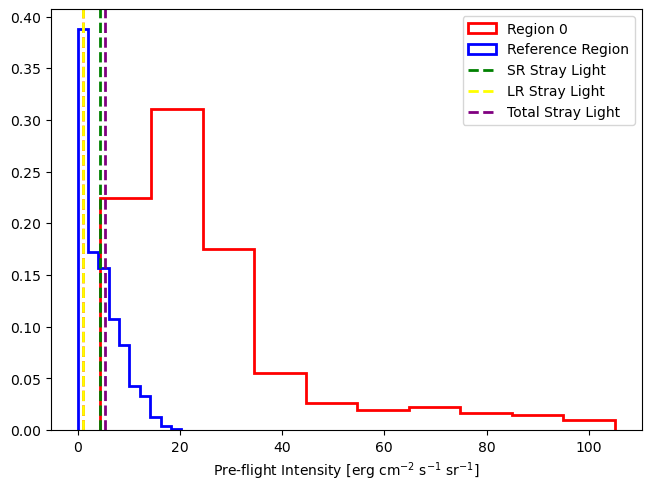

In [67]:
eis_FeXVI_262_upflow_regions_int_mean_radcal, \
eis_FeXVI_262_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_16_262_984.1c-0', cs_regions,
                                                                                    int_hist=0, min=1,
                                                                                  reference_region_params=coronal_hole_ref_region_params,
                                                                                  short_range_stray_light=True,
                                                                                  long_range_stray_light=True,
                                                                                  long_range_stray_light_aia_ref=aia_335_map,
                                                                                  long_range_stray_light_ref_center=[-390,250]*u.arcsec,
                                                                                  long_range_stray_light_ref_radius=50*u.arcsec)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.o__04_279_933.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_81952/3029816634.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 700x500 with 2 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)


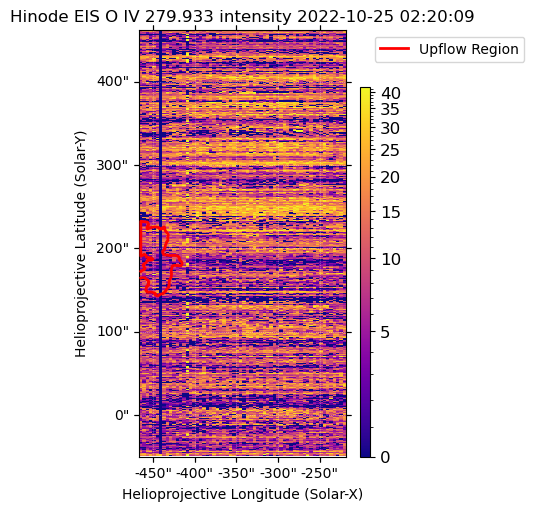

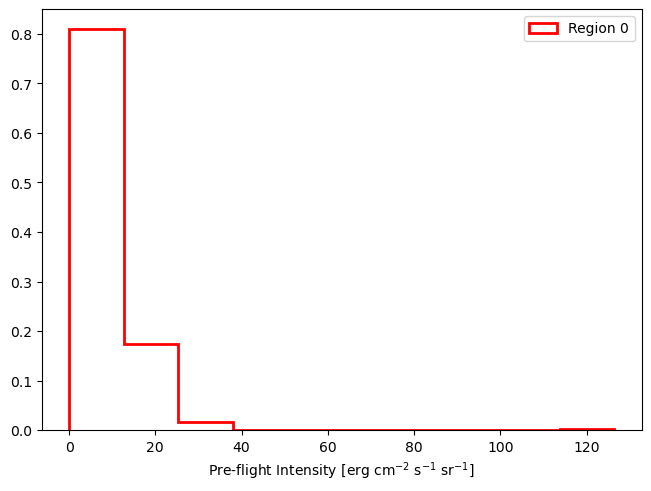

In [68]:
eis_OIV_279_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'o__04_279_933.1c-0', cs_regions)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.o__06_184_117.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_81952/3029816634.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 700x500 with 2 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)


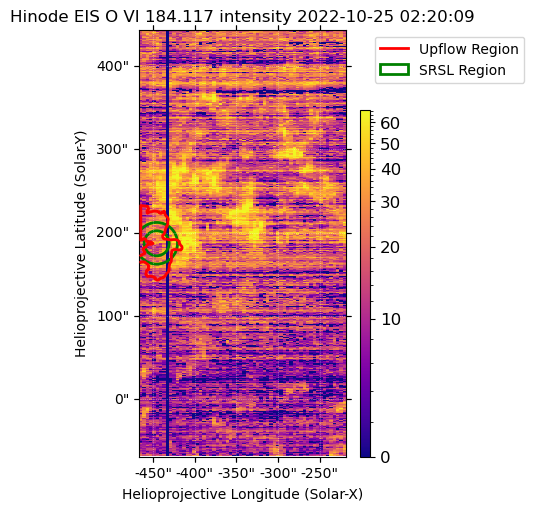

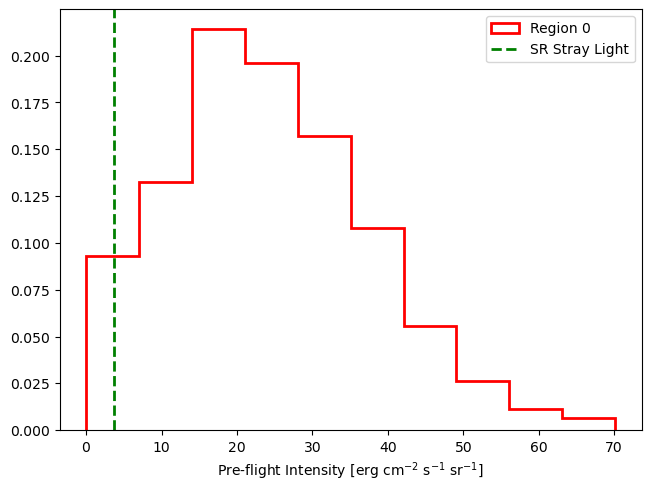

In [69]:
eis_OVI_184_upflow_regions_int_mean_radcal, \
eis_OVI_184_upflow_regions_stray_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'o__06_184_117.1c-0', cs_regions,
                                                                                 short_range_stray_light=True,)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.mg_06_270_394.2c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_81952/3029816634.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 700x500 with 2 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)


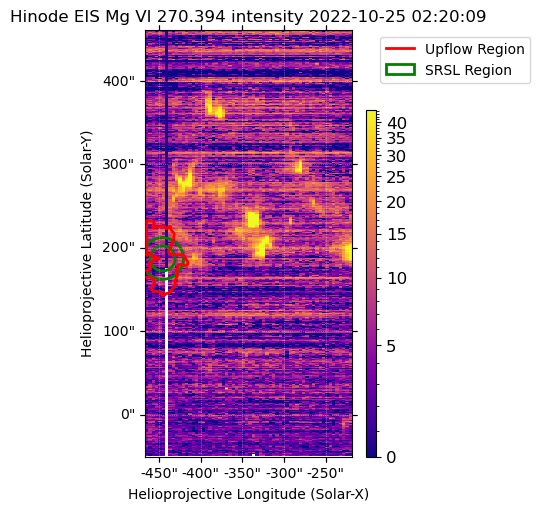

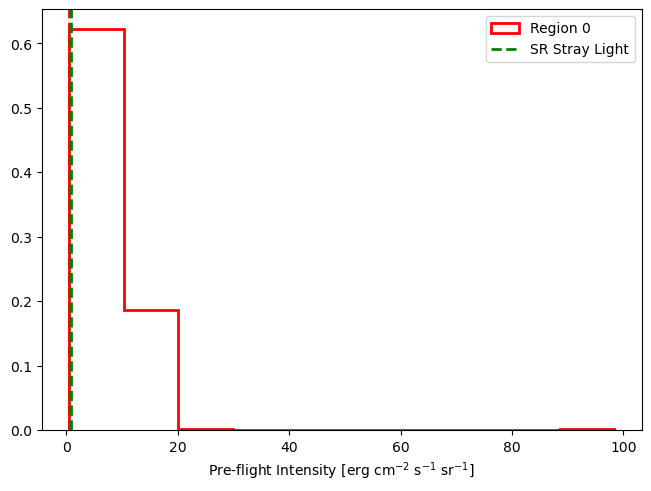

In [70]:
eis_MgVI_270_upflow_regions_int_mean_radcal, \
eis_MgVI_270_upflow_regions_stray_light_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'mg_06_270_394.2c-0', cs_regions,
                                                                                 min=0.5,short_range_stray_light=True,)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.si_07_275_368.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_81952/3029816634.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 700x500 with 2 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)


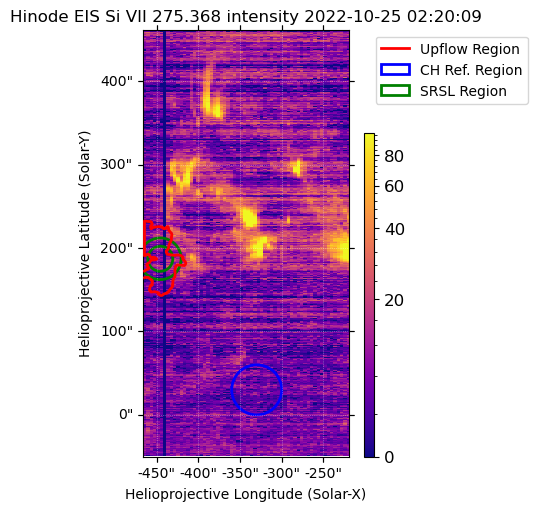

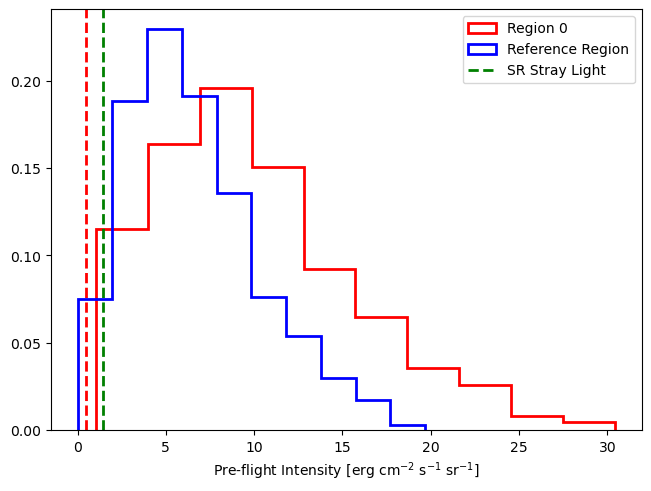

In [71]:
eis_SiVII_275_upflow_regions_int_mean_radcal, \
eis_SiVII_275_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'si_07_275_368.1c-0', cs_regions,min=0.5,
                                                                                         reference_region_params=coronal_hole_ref_region_params,
                                                                                         short_range_stray_light=True,)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.mg_07_276_153.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_81952/3029816634.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 700x500 with 2 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)


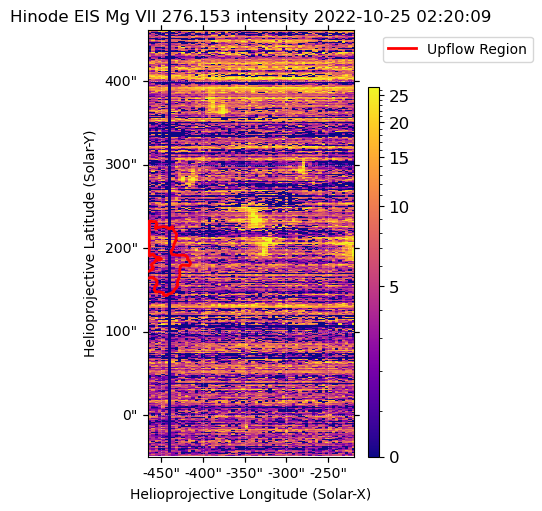

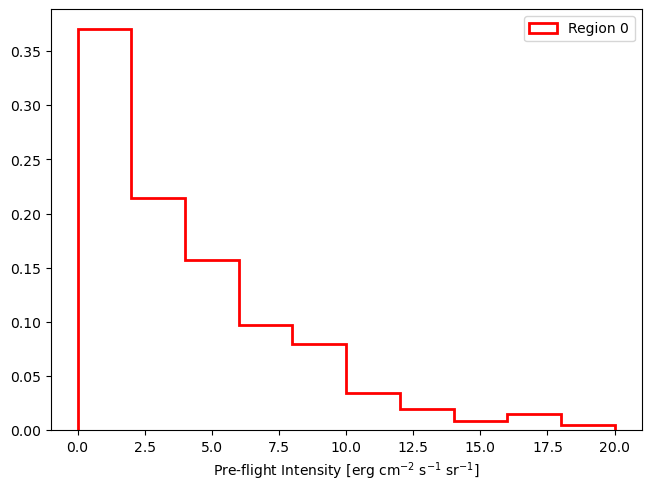

In [72]:
eis_MgVII_276_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'mg_07_276_153.1c-0', cs_regions,
                                                                                  int_hist=0)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.mg_07_280_737.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_81952/3029816634.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 700x500 with 2 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)


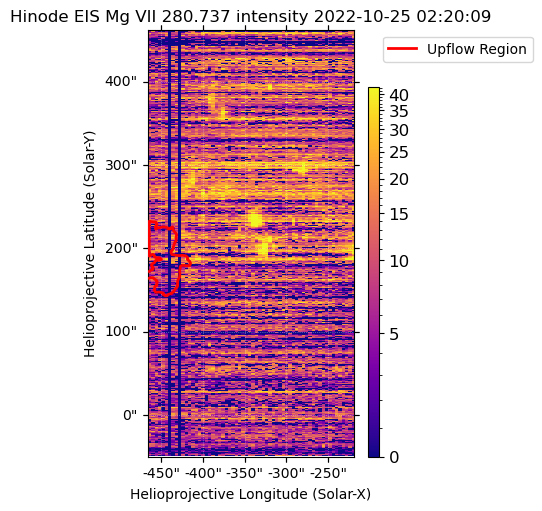

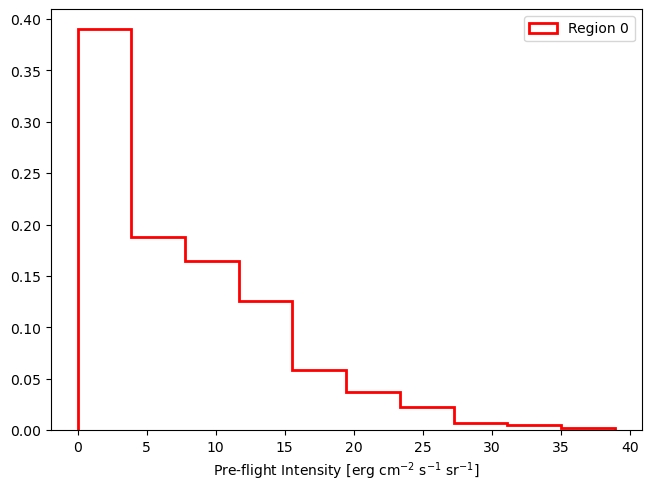

In [73]:
eis_MgVII_280_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'mg_07_280_737.1c-0', cs_regions,
                                                                                  int_hist=0)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.si_10_258_375.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_81952/3029816634.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 700x500 with 2 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)


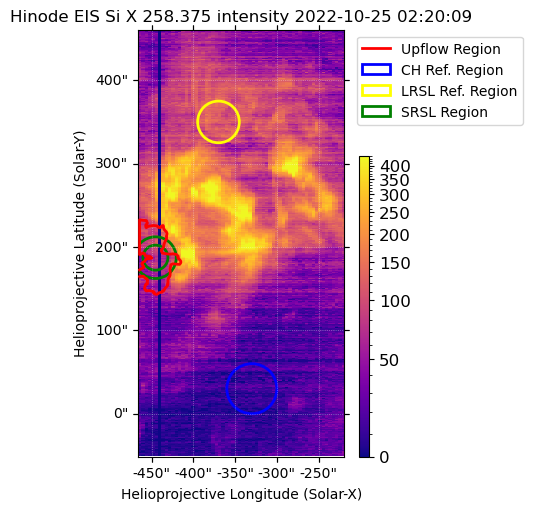

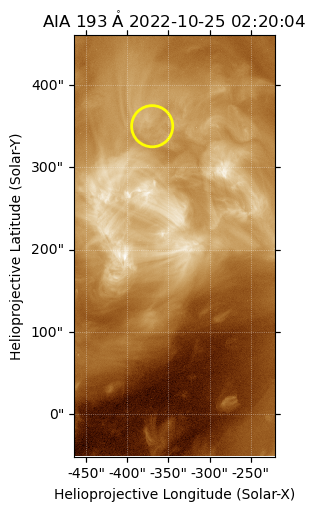

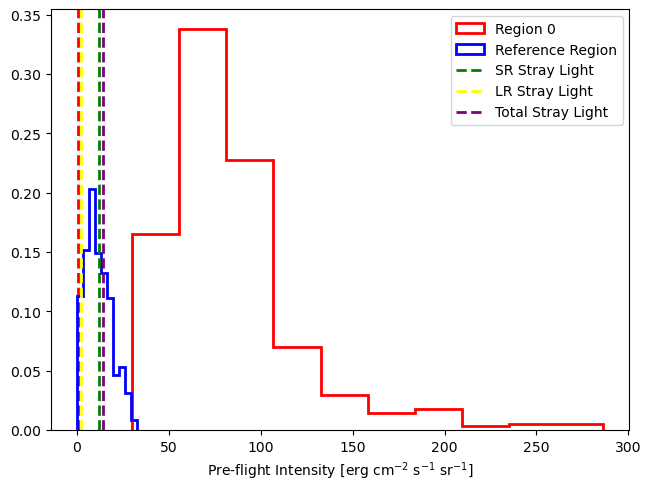

In [74]:
eis_SiX_258_upflow_regions_int_mean_radcal, \
eis_SiX_258_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'si_10_258_375.1c-0', cs_regions,
                                                                                min=0.5,
                                                                                reference_region_params=coronal_hole_ref_region_params,
                                                                                short_range_stray_light=True,
                                                                                long_range_stray_light=True,
                                                                                long_range_stray_light_aia_ref=aia_193_map,
                                                                                long_range_stray_light_ref_center=[-370,350]*u.arcsec,
                                                                                long_range_stray_light_ref_radius=50*u.arcsec)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221025T0023/eis_20221025_014811.si_10_261_058.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/tmp/ipykernel_81952/3029816634.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 700x500 with 2 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)


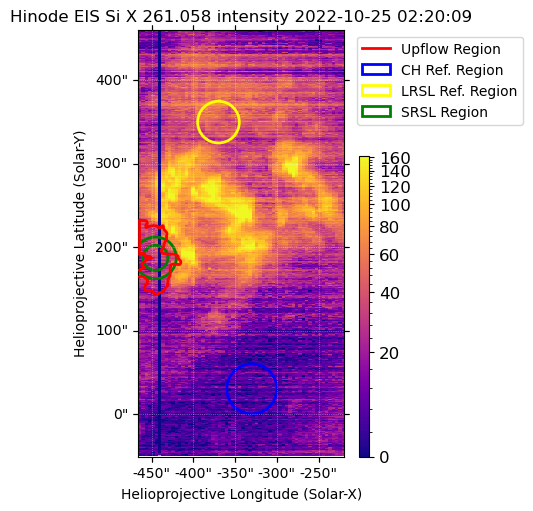

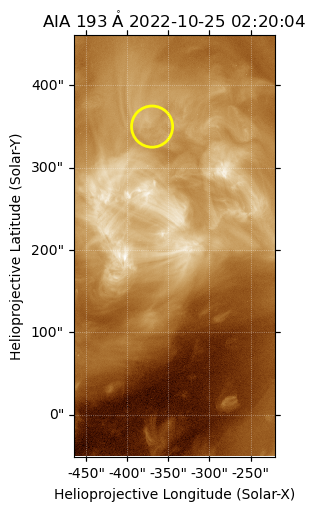

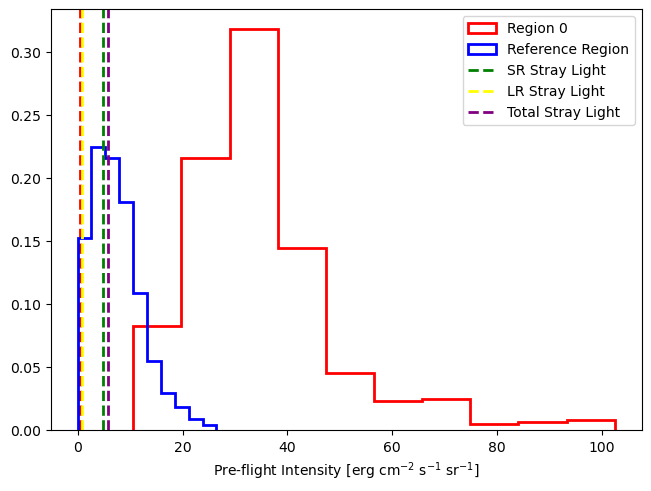

In [75]:
eis_SiX_261_upflow_regions_int_mean_radcal, \
eis_SiX_261_upflow_regions_stray_light_int_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'si_10_261_058.1c-0', cs_regions,
                                                                                       min=0.5,
                                                                                reference_region_params=coronal_hole_ref_region_params,
                                                                                short_range_stray_light=True,
                                                                                long_range_stray_light=True,
                                                                                long_range_stray_light_aia_ref=aia_193_map,
                                                                                long_range_stray_light_ref_center=[-370,350]*u.arcsec,
                                                                                long_range_stray_light_ref_radius=50*u.arcsec)

In [76]:
def dens_diag(ratio, chianti_file):
    chianti_pf = pd.read_csv(chianti_file,skiprows=6,sep=r'\s+',names=['dens','ratio'])
    chianti_dens, chianti_ratio = chianti_pf['dens'], chianti_pf['ratio']
    if np.all(np.diff(chianti_ratio) < 0):
        chianti_ratio = chianti_ratio[::-1]
        chianti_dens = chianti_dens[::-1]

    dens_interp_func = scipy.interpolate.interp1d(chianti_ratio, chianti_dens, kind='linear', fill_value='extrapolate')

    return dens_interp_func(ratio)

In [77]:
SiX_dens_upflow_regions = dens_diag(eis_SiX_258_upflow_regions_int_mean_radcal/eis_SiX_261_upflow_regions_int_mean_radcal,
                                    '../../sav/CHIANTI/SiX_258_261_dens.txt')
SiX_dens_upflow_regions

array([3.36208065e+08])

In [78]:
SiX_dens_upflow_regions_sl_removed = dens_diag((eis_SiX_258_upflow_regions_int_mean_radcal - np.nansum(eis_SiX_258_upflow_regions_stray_light_int_radcal,axis=1))/
                                               (eis_SiX_261_upflow_regions_int_mean_radcal - np.nansum(eis_SiX_261_upflow_regions_stray_light_int_radcal,axis=1)),
                                               '../../sav/CHIANTI/SiX_258_261_dens.txt')
SiX_dens_upflow_regions_sl_removed

array([3.258457e+08])

In [79]:
MgVII_dens_upflow_regions = dens_diag(eis_MgVII_276_upflow_regions_int_mean_radcal/eis_MgVII_280_upflow_regions_int_mean_radcal,
                                        '../../sav/CHIANTI/MgVII_276_280.txt')
MgVII_dens_upflow_regions

array([1.81080639e+09])

In [80]:
FeXIII_dens_upflow_regions = dens_diag(eis_FeXIII_202_upflow_regions_int_mean_radcal/eis_FeXIII_203_826_upflow_regions_int_mean_radcal,
                                        '../../sav/CHIANTI/FeXIII_202_203_dens.txt')
FeXIII_dens_upflow_regions

array([2.88864383e+08])

In [81]:
FeXIII_dens_upflow_regions_sl_removed = dens_diag((eis_FeXIII_202_upflow_regions_int_mean_radcal - np.nansum(eis_FeXIII_202_upflow_regions_stray_light_int_radcal,axis=1))/
                                                    (eis_FeXIII_203_826_upflow_regions_int_mean_radcal - np.nansum(eis_FeXIII_203_826_upflow_regions_stray_light_int_radcal,axis=1)),
                                                    '../../sav/CHIANTI/FeXIII_202_203_dens.txt')
FeXIII_dens_upflow_regions_sl_removed

array([2.86280081e+08])

In [82]:
upflow_region_0_dem_wvl = np.array([185.213, 186.598, 188.493, 197.854, 184.537,
                                    188.216, 188.299, 192.394, 195.119, 203.728,
                                    202.044, 203.826, 264.788, 270.520, 284.163, 
                                    262.976])
upflow_region_0_dem_int = np.vstack([eis_FeVIII_185_upflow_regions_int_mean_radcal,
                                     eis_FeVIII_186_upflow_regions_int_mean_radcal,
                                     eis_FeIX_188_upflow_regions_int_mean_radcal,
                                     eis_FeIX_197_upflow_regions_int_mean_radcal,
                                     eis_FeX_184_upflow_regions_int_mean_radcal,
                                     eis_FeXI_188_216_upflow_regions_int_mean_radcal,
                                     eis_FeXI_188_299_upflow_regions_int_mean_radcal,
                                     eis_FeXII_192_upflow_regions_int_mean_radcal,
                                     eis_FeXII_195_upflow_regions_int_mean_radcal,
                                     eis_FeXII_203_720_upflow_regions_int_mean_radcal,
                                     eis_FeXIII_202_upflow_regions_int_mean_radcal,
                                     eis_FeXIII_203_826_upflow_regions_int_mean_radcal,
                                     eis_FeXIV_264_upflow_regions_int_mean_radcal,
                                     eis_FeXIV_270_upflow_regions_int_mean_radcal,
                                     eis_FeXV_284_upflow_regions_int_mean_radcal,
                                     eis_FeXVI_262_upflow_regions_int_mean_radcal])[:,0]

upflow_region_0_dem_int_err = upflow_region_0_dem_int*0.2

upflow_region_0_den_wvl_hwhm = np.ones_like(upflow_region_0_dem_wvl)*0.05
upflow_region_0_den_wvl_hwhm[11] = 0.05

upflow_region_0_dem_des = ['Fe VIII 185', 'Fe VIII 186', 'Fe IX 188', 'Fe IX 197', 'Fe X 184',
                           'Fe XI 188.216', 'Fe XI 188.299', 'Fe XII 192', 'Fe XII 195', 'Fe XII 203.720',
                           'Fe XIII 202', 'Fe XIII 203.826/.795', 'Fe XIV 264', 'Fe XIV 270', 'Fe XV 284',
                           'Fe XVI 262']


In [83]:
upflow_region_0_chianti_input_pf = pd.DataFrame({'wvl':upflow_region_0_dem_wvl,
                                                    'int':upflow_region_0_dem_int,
                                                    'int_err':upflow_region_0_dem_int_err,
                                                    'hwhm':upflow_region_0_den_wvl_hwhm,
                                                    'des':upflow_region_0_dem_des})
upflow_region_0_chianti_input_pf.to_csv('../../sav/CHIANTI/dem_input/east_upflow_region_0_chianti_input_pf_5kms.txt',index=False,
                                        header=False, sep=' ',)
upflow_region_0_chianti_input_pf

wvl          int     int_err  hwhm                   des
0   185.213    58.315718   11.663144  0.05           Fe VIII 185
1   186.598    27.102936    5.420587  0.05           Fe VIII 186
2   188.493    15.508275    3.101655  0.05             Fe IX 188
3   197.854    11.122827    2.224565  0.05             Fe IX 197
4   184.537   116.945240   23.389048  0.05              Fe X 184
5   188.216   203.611367   40.722273  0.05         Fe XI 188.216
6   188.299   133.417581   26.683516  0.05         Fe XI 188.299
7   192.394   121.405007   24.281001  0.05            Fe XII 192
8   195.119   514.752305  102.950461  0.05            Fe XII 195
9   203.728    32.241954    6.448391  0.05        Fe XII 203.720
10  202.044   373.876561   74.775312  0.05           Fe XIII 202
11  203.826   141.495364   28.299073  0.05  Fe XIII 203.826/.795
12  264.788   459.389863   91.877973  0.05            Fe XIV 264
13  270.520   320.560627   64.112125  0.05            Fe XIV 270
14  284.163  2042.738169  408.547634  0.05             Fe XV 284
15  262.976    87.015866   17.403173  0.05            Fe XVI 262

In [84]:
upflow_region_0_dem_int_sr_removed = \
    np.array([eis_FeVIII_185_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeVIII_185_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeVIII_186_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeVIII_186_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeIX_188_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeIX_188_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeIX_197_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeIX_197_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeX_184_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeX_184_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeXI_188_216_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeXI_188_216_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeXI_188_299_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeXI_188_299_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeXII_192_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeXII_192_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeXII_195_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeXII_195_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeXII_203_720_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeXII_203_720_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeXIII_202_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeXIII_202_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeXIII_203_826_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeXIII_203_826_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeXIV_264_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeXIV_264_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeXIV_270_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeXIV_270_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeXV_284_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeXV_284_upflow_regions_stray_light_int_radcal[0,:]),
              eis_FeXVI_262_upflow_regions_int_mean_radcal[0] - np.nansum(eis_FeXVI_262_upflow_regions_stray_light_int_radcal[0,:])])

upflow_region_0_dem_int_sr_removed_err = upflow_region_0_dem_int_sr_removed*0.23


In [85]:
upflow_region_0_chianti_input_pf_sr_removed = pd.DataFrame({'wvl':upflow_region_0_dem_wvl,
                                                    'int':upflow_region_0_dem_int_sr_removed,
                                                    'int_err':upflow_region_0_dem_int_sr_removed_err,
                                                    'hwhm':upflow_region_0_den_wvl_hwhm,
                                                    'des':upflow_region_0_dem_des})
upflow_region_0_chianti_input_pf_sr_removed.to_csv('../../sav/CHIANTI/dem_input/east_upflow_region_0_chianti_input_pf_sr_removed_5kms.txt',index=False,
                                        header=False, sep=' ',)
upflow_region_0_chianti_input_pf_sr_removed

wvl          int     int_err  hwhm                   des
0   185.213    46.604705   10.719082  0.05           Fe VIII 185
1   186.598    21.774869    5.008220  0.05           Fe VIII 186
2   188.493    12.247195    2.816855  0.05             Fe IX 188
3   197.854     8.842882    2.033863  0.05             Fe IX 197
4   184.537    94.525100   21.740773  0.05              Fe X 184
5   188.216   165.224419   38.001616  0.05         Fe XI 188.216
6   188.299   108.241211   24.895479  0.05         Fe XI 188.299
7   192.394   102.247654   23.516960  0.05            Fe XII 192
8   195.119   422.255105   97.118674  0.05            Fe XII 195
9   203.728    26.275762    6.043425  0.05        Fe XII 203.720
10  202.044   305.374496   70.236134  0.05           Fe XIII 202
11  203.826   114.414848   26.315415  0.05  Fe XIII 203.826/.795
12  264.788   373.423489   85.887403  0.05            Fe XIV 264
13  270.520   263.204364   60.537004  0.05            Fe XIV 270
14  284.163  1740.806271  400.385442  0.05             Fe XV 284
15  262.976    69.408769   15.964017  0.05            Fe XVI 262

In [86]:
dem_xrt_output_test = readsav('../../sav/CHIANTI/dem_output/east_upflow_region_0_sr_removed_5kms/east_upflow_region_0_chianti_output_xrt_dem.save',
                          verbose=True)

IDL Save file is compressed
 -> expanding to /tmp/tmpbpgbxp6u.sav
--------------------------------------------------
Date: Wed Jul 10 17:07:19 2024
User: yjzhu
Host: Yingjies-MacBook-Pro.local
--------------------------------------------------
Format: 11
Architecture: x86_64
Operating System: darwin
IDL Version: 8.2
--------------------------------------------------
Successfully read 12 records of which:
 - 1 are of type TIMESTAMP
 - 9 are of type VARIABLE
 - 1 are of type VERSION
--------------------------------------------------
Available variables:
 - logt_out [<class 'numpy.ndarray'>]
 - log_dem_mciter [<class 'numpy.ndarray'>]
 - obs_int [<class 'numpy.ndarray'>]
 - obs_sig [<class 'numpy.ndarray'>]
 - obs_id [<class 'numpy.ndarray'>]
 - obs_wvl [<class 'numpy.ndarray'>]
 - exp_int [<class 'numpy.ndarray'>]
 - t_eff [<class 'numpy.ndarray'>]
 - temp_max_tot_contr [<class 'numpy.ndarray'>]
--------------------------------------------------


In [87]:
dem_mpfit_output_test = readsav('../../sav/CHIANTI/dem_output/east_upflow_region_0_sr_removed_5kms/east_upflow_region_0_chianti_output_mpfit_dem.save',
                          verbose=True)

IDL Save file is compressed
 -> expanding to /tmp/tmp6k3u6db2.sav
--------------------------------------------------
Date: Wed Jul 10 17:02:16 2024
User: yjzhu
Host: Yingjies-MacBook-Pro.local
--------------------------------------------------
Format: 11
Architecture: x86_64
Operating System: darwin
IDL Version: 8.2
--------------------------------------------------
Successfully read 13 records of which:
 - 1 are of type TIMESTAMP
 - 10 are of type VARIABLE
 - 1 are of type VERSION
--------------------------------------------------
Available variables:
 - ch_tot_contr_interpolated [<class 'numpy.ndarray'>]
 - logt_interpolated [<class 'numpy.ndarray'>]
 - logt_out [<class 'numpy.ndarray'>]
 - log_dem_out [<class 'numpy.ndarray'>]
 - obs_int [<class 'numpy.ndarray'>]
 - obs_id [<class 'numpy.ndarray'>]
 - obs_wvl [<class 'numpy.ndarray'>]
 - exp_int [<class 'numpy.ndarray'>]
 - t_eff [<class 'numpy.ndarray'>]
 - temp_max_tot_contr [<class 'numpy.ndarray'>]
------------------------------

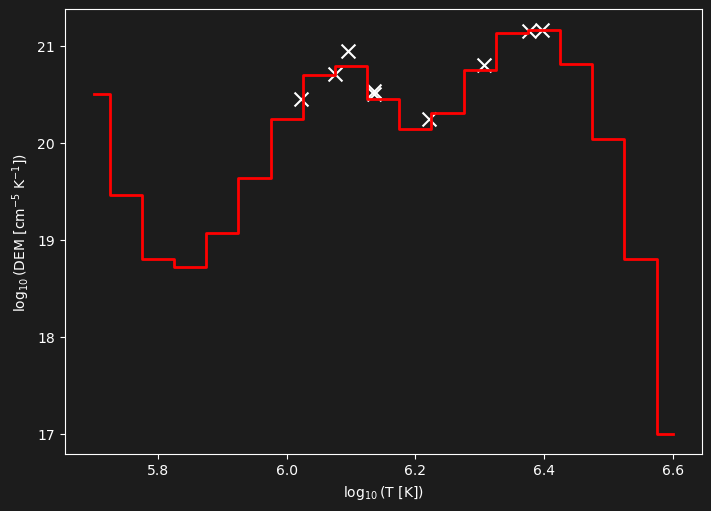

In [88]:
with plt.style.context('dark_background'):
    fig = plt.figure(figsize=(7, 5),layout='constrained', facecolor='#1C1C1C')
    ax = fig.add_subplot(111, facecolor='#1C1C1C')

    ax.step(dem_mpfit_output_test['logt_out'], dem_mpfit_output_test['log_dem_out'], where='mid', color='red', lw=2,)

    for teff, exp_int, obs_int, line_id in zip(dem_mpfit_output_test['t_eff'], 
                                               dem_mpfit_output_test['exp_int'],
                                               dem_mpfit_output_test['obs_int'],
                                               dem_mpfit_output_test['obs_id']):
        
        # print(np.log10(teff), exp_int/obs_int, line_id.decode("utf-8"))

        # ax.text(np.log10(teff), exp_int/obs_int*np.interp(np.log10(teff), dem_mpfit_output_test['logt_out'], dem_mpfit_output_test['log_dem_out']),
        #          line_id.decode("utf-8")[1:-1], color='white', fontsize=12, ha='center', va='bottom',rotation=90) 
        
        ax.scatter(np.log10(teff), np.log10(obs_int/exp_int)+np.interp(np.log10(teff), dem_mpfit_output_test['logt_out'], dem_mpfit_output_test['log_dem_out']),
                    color='white', marker='x', s=100)

        


    ax.set_xlabel(r'$\log_{10}$(T [K])')
    ax.set_ylabel(r'$\log_{10}$(DEM [cm$^{-5}$ K$^{-1}$])')



In [89]:
eis_FeXII_195_vnth_upflow_regions = get_intensity_from_cs_regions(eis_FeXII_195_vnthmap, cs_regions)
eis_FeXII_195_vel_upflow_regions = get_intensity_from_cs_regions(eis_FeXII_195_velmap, cs_regions)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


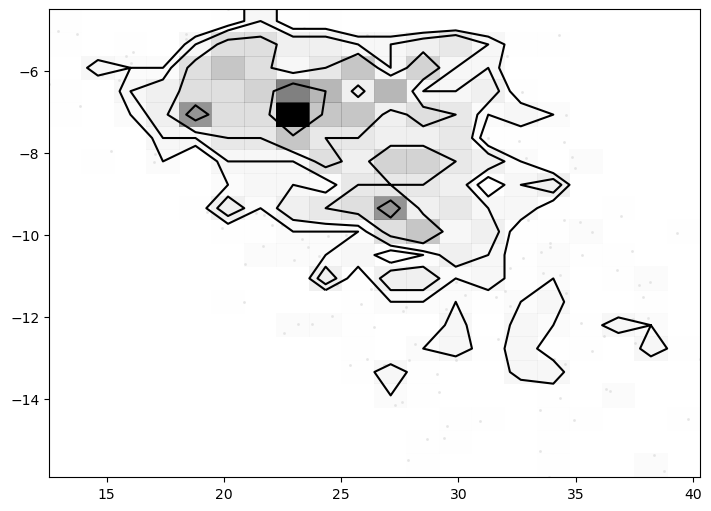

In [90]:
fig, ax = plt.subplots(figsize=(7, 5),layout='constrained')
corner.hist2d(eis_FeXII_195_vnth_upflow_regions[0], eis_FeXII_195_vel_upflow_regions[0], ax=ax)